In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

### Data

In [15]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [16]:
tree_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [17]:
class DataFile(object):
    def __init__(self, path, name):
        self.path = path
        self.name = name
        self.raw = uproot.open(self.path)
    def features(self):
        return self.raw.keys()
    def true_features(self):
        return [name for name in self.raw.keys() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=aliases, library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [19]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [20]:
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [21]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [22]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [23]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [24]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [25]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [26]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [27]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [28]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          970116   247104  197683   49421       0.254716
B⁺→K⁺J/ψ(→ee)    960234   929755  743804  185951       0.968259
B⁺→K⁺ψ(2S)(→ee)  986271   939679  751743  187936       0.952759
D⁺→π⁺φ(→ee)      830027   830027  664021  166006            1.0

### KS tests

In [29]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [30]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [31]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
            density=True, histtype='step', bins=bins, **kwargs)
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

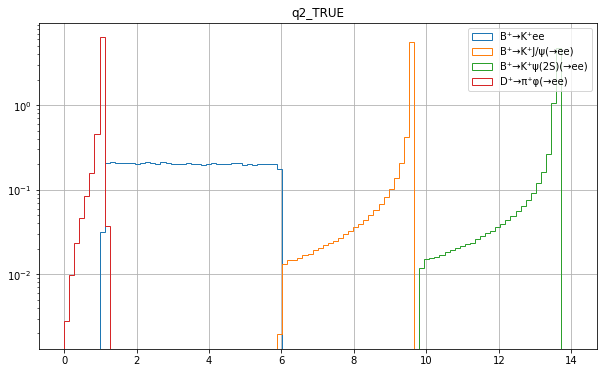

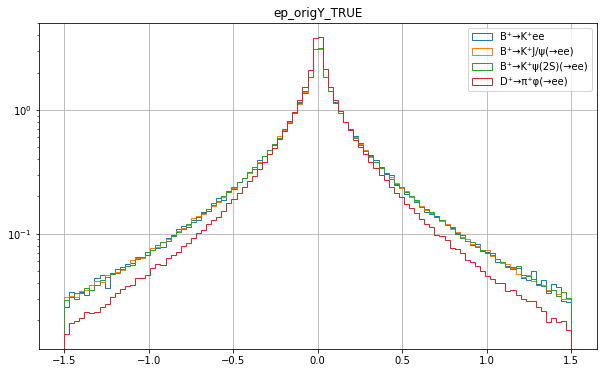

In [32]:
feature_plot("alpha", train_ds, aliases, np.linspace(0, 0.5, 101))
feature_plot("log_max_pl", train_ds, aliases, np.linspace(0, 7, 101))
feature_plot("q2_TRUE", train_ds, aliases, np.linspace(0, 14, 101), log=True)
feature_plot("ep_origY_TRUE", train_ds, aliases, np.linspace(-1.5, 1.5, 101), log=True)

### Preprocessing

In [33]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [34]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [35]:
feature_sets = [
    ("α", ["alpha"]),
    ("α,p", ["alpha", "log_max_pl"]),
    ("pt,pt", ["log_ep_PT", "log_em_PT"])
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

ds_a4 = Dataset(["alpha"], train_ds, aliases, "₄[α]")
ds_a3 = Dataset(["alpha"], train_ds[:3], aliases, "₃[α]")
ds_la4 = Dataset(["alpha", "log_max_pl"], train_ds, aliases, "₄[α,p]")
ds_la3 = Dataset(["alpha", "log_max_pl"], train_ds[:3], aliases, "₃[α,p]")
ds_pt4 = Dataset(["log_ep_PT", "log_em_PT"], train_ds, aliases, "₄[pt,pt]")
ds_pt3 = Dataset(["log_ep_PT", "log_em_PT"], train_ds[:3], aliases, "₃[pt,pt]")

In [36]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(to_numpy(dataset.X()))
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [37]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.inverse_transform(lower)[0]
    x_max, y_max = sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

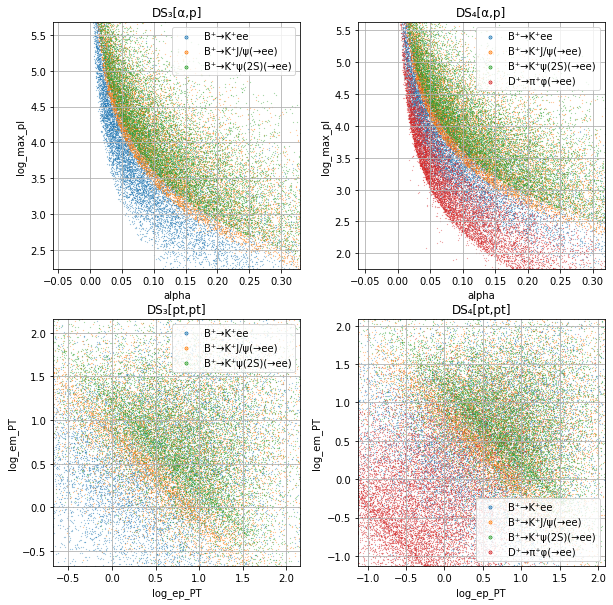

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_ds(ds_la3, scale=2.0, ax=ax[0,0])
plot_ds(ds_la4, scale=2.0, ax=ax[0,1])
plot_ds(ds_pt3, scale=2.0, ax=ax[1,0])
plot_ds(ds_pt4, scale=2.0, ax=ax[1,1])
plt.show()

### NN

In [39]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [40]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [41]:
def plot_one(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = dataset.inverse_transform([[-3.0], [3.0]])
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(dataset.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [42]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [43]:
class Estimator(object):
    def __init__(self, dataset):
        self.features = dataset.features
        self.scaler = Scaler(dataset)
        self.model = torch.nn.Sequential(
            self.scaler,
            model(len(dataset.features), len(dataset.sources))
        ).to(device)
    def train(self, dataset, device=device):
        assert dataset.features == self.features
        return train_estimator(dataset, self.model, device=device)

In [44]:
def plot_field(f, scaler, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = scaler.inverse_transform(lower)[0]
    x_max, y_max = scaler.inverse_transform(upper)[0]
    
    sc1 = scale+1
    X_test = scaler.inverse_transform(np.asarray(bridson.poisson_disc_samples(2*sc1, 2*sc1, 0.02)) - sc1)
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(scaler.features[0])
    axis.set_ylabel(scaler.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [45]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [46]:
def plot_clf_min_max(clf, scaler, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), scaler, scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), scaler, scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [47]:
%%time
e_a4 = Estimator(ds_a4)
e_a4.train(ds_a4)

INFO:root:Epoch 0, 1.412630
INFO:root:Epoch 1, 1.384332
INFO:root:Epoch 2, 1.381191
INFO:root:Epoch 3, 1.376762
INFO:root:Epoch 4, 1.370938
INFO:root:Epoch 5, 1.366992
INFO:root:Epoch 6, 1.366049
INFO:root:Epoch 7, 1.365631
INFO:root:Epoch 8, 1.365296
INFO:root:Epoch 9, 1.365039
INFO:root:Epoch 10, 1.364837
INFO:root:Epoch 11, 1.364676
INFO:root:Epoch 12, 1.364538
INFO:root:Epoch 13, 1.364445
INFO:root:Epoch 14, 1.364358
INFO:root:Epoch 15, 1.364298
INFO:root:Epoch 16, 1.364252
INFO:root:Epoch 17, 1.364217
INFO:root:Epoch 18, 1.364182
INFO:root:Epoch 19, 1.364160
INFO:root:Epoch 20, 1.364127
INFO:root:Epoch 21, 1.364110
INFO:root:Epoch 22, 1.364084
INFO:root:Epoch 23, 1.364069
INFO:root:Epoch 24, 1.364046
INFO:root:Epoch 25, 1.364021
INFO:root:Epoch 26, 1.364007
INFO:root:Epoch 27, 1.363988
INFO:root:Epoch 28, 1.363965
INFO:root:Epoch 29, 1.363949
INFO:root:Epoch 30, 1.363931
INFO:root:Epoch 31, 1.363913
INFO:root:Epoch 32, 1.363896
INFO:root:Epoch 33, 1.363889
INFO:root:Epoch 34, 1.36

CPU times: user 31.7 s, sys: 2.85 s, total: 34.5 s
Wall time: 34.2 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [48]:
%%time
e_a3 = Estimator(ds_a3)
e_a3.train(ds_a3)

INFO:root:Epoch 0, 1.100438
INFO:root:Epoch 1, 1.097309
INFO:root:Epoch 2, 1.094772
INFO:root:Epoch 3, 1.090908
INFO:root:Epoch 4, 1.085254
INFO:root:Epoch 5, 1.080084
INFO:root:Epoch 6, 1.078243
INFO:root:Epoch 7, 1.077958
INFO:root:Epoch 8, 1.077748
INFO:root:Epoch 9, 1.077639
INFO:root:Epoch 10, 1.077461
INFO:root:Epoch 11, 1.077325
INFO:root:Epoch 12, 1.077223
INFO:root:Epoch 13, 1.077165
INFO:root:Epoch 14, 1.077084
INFO:root:Epoch 15, 1.076973
INFO:root:Epoch 16, 1.076905
INFO:root:Epoch 17, 1.076838
INFO:root:Epoch 18, 1.076794
INFO:root:Epoch 19, 1.076721
INFO:root:Epoch 20, 1.076689
INFO:root:Epoch 21, 1.076661
INFO:root:Epoch 22, 1.076606
INFO:root:Epoch 23, 1.076574
INFO:root:Epoch 24, 1.076521
INFO:root:Epoch 25, 1.076493
INFO:root:Epoch 26, 1.076462
INFO:root:Epoch 27, 1.076443
INFO:root:Epoch 28, 1.076421
INFO:root:Epoch 29, 1.076410
INFO:root:Epoch 30, 1.076386
INFO:root:Epoch 31, 1.076351
INFO:root:Epoch 32, 1.076309
INFO:root:Epoch 33, 1.076280
INFO:root:Epoch 34, 1.07

CPU times: user 23.2 s, sys: 1.14 s, total: 24.4 s
Wall time: 24.2 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [49]:
%%time
e_la4 = Estimator(ds_la4)
e_la4.train(ds_la4)

INFO:root:Epoch 0, 1.449750
INFO:root:Epoch 1, 1.387725
INFO:root:Epoch 2, 1.379734
INFO:root:Epoch 3, 1.370471
INFO:root:Epoch 4, 1.354262
INFO:root:Epoch 5, 1.322284
INFO:root:Epoch 6, 1.261276
INFO:root:Epoch 7, 1.160207
INFO:root:Epoch 8, 1.066335
INFO:root:Epoch 9, 1.035311
INFO:root:Epoch 10, 1.019559
INFO:root:Epoch 11, 1.004032
INFO:root:Epoch 12, 0.986067
INFO:root:Epoch 13, 0.963699
INFO:root:Epoch 14, 0.936757
INFO:root:Epoch 15, 0.910202
INFO:root:Epoch 16, 0.892244
INFO:root:Epoch 17, 0.882975
INFO:root:Epoch 18, 0.876498
INFO:root:Epoch 19, 0.870758
INFO:root:Epoch 20, 0.865707
INFO:root:Epoch 21, 0.861317
INFO:root:Epoch 22, 0.857602
INFO:root:Epoch 23, 0.854715
INFO:root:Epoch 24, 0.852147
INFO:root:Epoch 25, 0.850106
INFO:root:Epoch 26, 0.848181
INFO:root:Epoch 27, 0.846406
INFO:root:Epoch 28, 0.844773
INFO:root:Epoch 29, 0.843237
INFO:root:Epoch 30, 0.841683
INFO:root:Epoch 31, 0.840255
INFO:root:Epoch 32, 0.838917
INFO:root:Epoch 33, 0.837558
INFO:root:Epoch 34, 0.83

CPU times: user 34.7 s, sys: 2.87 s, total: 37.6 s
Wall time: 37.3 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [50]:
%%time
e_la3 = Estimator(ds_la3)
e_la3.train(ds_la3)

INFO:root:Epoch 0, 1.122119
INFO:root:Epoch 1, 1.099700
INFO:root:Epoch 2, 1.096479
INFO:root:Epoch 3, 1.093454
INFO:root:Epoch 4, 1.089224
INFO:root:Epoch 5, 1.082026
INFO:root:Epoch 6, 1.068820
INFO:root:Epoch 7, 1.045300
INFO:root:Epoch 8, 1.010117
INFO:root:Epoch 9, 0.973588
INFO:root:Epoch 10, 0.950975
INFO:root:Epoch 11, 0.938361
INFO:root:Epoch 12, 0.925510
INFO:root:Epoch 13, 0.911732
INFO:root:Epoch 14, 0.897566
INFO:root:Epoch 15, 0.885385
INFO:root:Epoch 16, 0.877837
INFO:root:Epoch 17, 0.873588
INFO:root:Epoch 18, 0.870149
INFO:root:Epoch 19, 0.866545
INFO:root:Epoch 20, 0.862912
INFO:root:Epoch 21, 0.859239
INFO:root:Epoch 22, 0.855432
INFO:root:Epoch 23, 0.851630
INFO:root:Epoch 24, 0.847770
INFO:root:Epoch 25, 0.843807
INFO:root:Epoch 26, 0.839894
INFO:root:Epoch 27, 0.835983
INFO:root:Epoch 28, 0.832117
INFO:root:Epoch 29, 0.828318
INFO:root:Epoch 30, 0.824595
INFO:root:Epoch 31, 0.821105
INFO:root:Epoch 32, 0.817781
INFO:root:Epoch 33, 0.814685
INFO:root:Epoch 34, 0.81

CPU times: user 25.7 s, sys: 1.19 s, total: 26.9 s
Wall time: 26.7 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [51]:
%%time
e_pt4 = Estimator(ds_pt4)
e_pt4.train(ds_pt4)

INFO:root:Epoch 0, 1.381931
INFO:root:Epoch 1, 1.354404
INFO:root:Epoch 2, 1.281815
INFO:root:Epoch 3, 1.154344
INFO:root:Epoch 4, 1.097159
INFO:root:Epoch 5, 1.089815
INFO:root:Epoch 6, 1.084366
INFO:root:Epoch 7, 1.079701
INFO:root:Epoch 8, 1.075398
INFO:root:Epoch 9, 1.071364
INFO:root:Epoch 10, 1.067602
INFO:root:Epoch 11, 1.064103
INFO:root:Epoch 12, 1.061094
INFO:root:Epoch 13, 1.058684
INFO:root:Epoch 14, 1.057049
INFO:root:Epoch 15, 1.056135
INFO:root:Epoch 16, 1.055668
INFO:root:Epoch 17, 1.055278
INFO:root:Epoch 18, 1.054984
INFO:root:Epoch 19, 1.054824
INFO:root:Epoch 20, 1.054646
INFO:root:Epoch 21, 1.054492
INFO:root:Epoch 22, 1.054331
INFO:root:Epoch 23, 1.054193
INFO:root:Epoch 24, 1.054025
INFO:root:Epoch 25, 1.053862
INFO:root:Epoch 26, 1.053701
INFO:root:Epoch 27, 1.053547
INFO:root:Epoch 28, 1.053336
INFO:root:Epoch 29, 1.053172
INFO:root:Epoch 30, 1.052988
INFO:root:Epoch 31, 1.052747
INFO:root:Epoch 32, 1.052555
INFO:root:Epoch 33, 1.052301
INFO:root:Epoch 34, 1.05

CPU times: user 34.4 s, sys: 2.78 s, total: 37.2 s
Wall time: 37 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [52]:
%%time
e_pt3 = Estimator(ds_pt3)
e_pt3.train(ds_pt3)

INFO:root:Epoch 0, 1.100740
INFO:root:Epoch 1, 1.093129
INFO:root:Epoch 2, 1.087765
INFO:root:Epoch 3, 1.079759
INFO:root:Epoch 4, 1.068369
INFO:root:Epoch 5, 1.056917
INFO:root:Epoch 6, 1.049444
INFO:root:Epoch 7, 1.044590
INFO:root:Epoch 8, 1.040640
INFO:root:Epoch 9, 1.037016
INFO:root:Epoch 10, 1.033504
INFO:root:Epoch 11, 1.030067
INFO:root:Epoch 12, 1.026692
INFO:root:Epoch 13, 1.023490
INFO:root:Epoch 14, 1.020353
INFO:root:Epoch 15, 1.017482
INFO:root:Epoch 16, 1.014847
INFO:root:Epoch 17, 1.012536
INFO:root:Epoch 18, 1.010694
INFO:root:Epoch 19, 1.009302
INFO:root:Epoch 20, 1.008374
INFO:root:Epoch 21, 1.007795
INFO:root:Epoch 22, 1.007411
INFO:root:Epoch 23, 1.007063
INFO:root:Epoch 24, 1.006773
INFO:root:Epoch 25, 1.006538
INFO:root:Epoch 26, 1.006358
INFO:root:Epoch 27, 1.006170
INFO:root:Epoch 28, 1.006109
INFO:root:Epoch 29, 1.005792
INFO:root:Epoch 30, 1.005521
INFO:root:Epoch 31, 1.005365
INFO:root:Epoch 32, 1.005174
INFO:root:Epoch 33, 1.004951
INFO:root:Epoch 34, 1.00

CPU times: user 25.3 s, sys: 1.19 s, total: 26.5 s
Wall time: 26.3 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

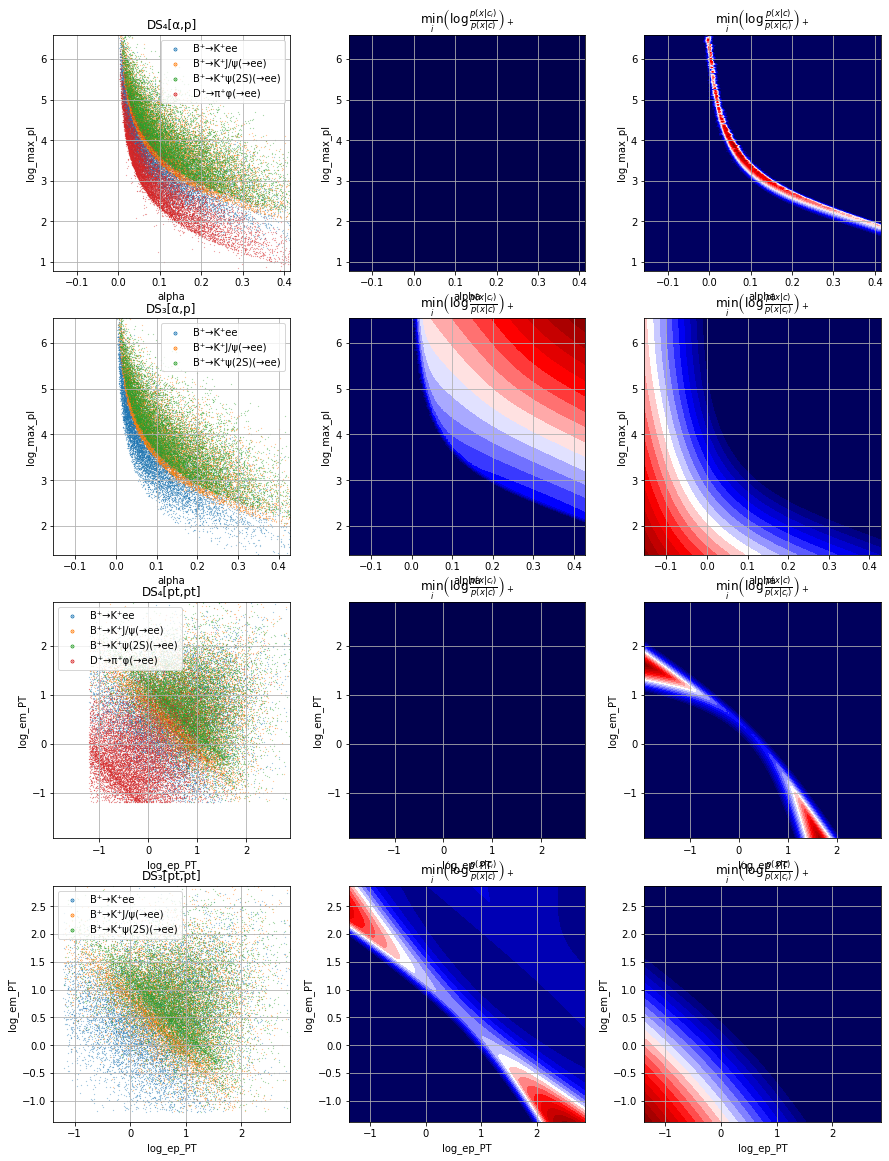

In [53]:
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
plot_ds(ds_la4, scaler=e_la4.scaler, ax=ax[0,0])
plot_clf_min_max(e_la4.model, e_la4.scaler, ax_min=ax[0,1], ax_max=ax[0,2])
plot_ds(ds_la3, scaler=e_la3.scaler, ax=ax[1,0])
plot_clf_min_max(e_la3.model, e_la3.scaler, ax_min=ax[1,1], ax_max=ax[1,2])
plot_ds(ds_pt4, scaler=e_pt4.scaler, ax=ax[2,0])
plot_clf_min_max(e_pt4.model, e_pt4.scaler, ax_min=ax[2,1], ax_max=ax[2,2])
plot_ds(ds_pt3, scaler=e_pt3.scaler, ax=ax[3,0])
plot_clf_min_max(e_pt3.model, e_pt3.scaler, ax_min=ax[3,1], ax_max=ax[3,2])
plt.show()

### Crafting a loss

In [54]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [55]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

In [56]:
def compute_lipschitz(model, loader, device=device):
    model.eval()
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [57]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [58]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [59]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [60]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [61]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [62]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [63]:
class Weighting:
    def __init__(self, estimator, name=None, n_classes=None, selected_class=0):
        model = clone_model(estimator.model)
        n_inputs = len(estimator.features)
        with torch.no_grad():
            n_outs = model(torch.zeros(1, n_inputs, dtype=float, device=device)).shape[1]
        n_classes = n_outs if n_classes is None else n_classes
        
        self.features = estimator.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.n_classes = n_classes
        self.name = name
        self.selected_class = selected_class
        
        self.model = torch.nn.Sequential(
            model[0],
            model[1:],
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def train(self, dataset, **kwargs):
        return train_weighting(self.model, dataset, self.n_outs, self.n_classes, self.selected_class, **kwargs)

In [64]:
%%time
w_la4 = Weighting(e_la4, name="w₄[α,p]")
w_la4.train(ds_la4, target_L=0.1)

Epoch 0 loss=-4.000080 W+c=[ 4.8622 -4.887   2.6629 -1.6645] det=0.000037 L=0.699043
Epoch 1 loss=-4.000082 W+c=[ 4.8591 -4.8544  2.5805 -1.6657] det=0.000038 L=0.705148
Epoch 2 loss=-4.000082 W+c=[ 4.8558 -4.8222  2.5026 -1.6668] det=0.000039 L=0.711258
Epoch 3 loss=-4.000081 W+c=[ 4.8526 -4.7903  2.4289 -1.6679] det=0.000041 L=0.717367
Epoch 4 loss=-4.000080 W+c=[ 4.8493 -4.7587  2.3591 -1.6691] det=0.000042 L=0.723472
Epoch 5 loss=-4.000081 W+c=[ 4.8459 -4.7274  2.2929 -1.6702] det=0.000043 L=0.729568
Epoch 6 loss=-4.000081 W+c=[ 4.8426 -4.6963  2.2301 -1.6713] det=0.000044 L=0.735653
Epoch 7 loss=-4.000081 W+c=[ 4.8391 -4.6656  2.1705 -1.6724] det=0.000045 L=0.741723
Epoch 8 loss=-4.000082 W+c=[ 4.8357 -4.6351  2.1137 -1.6735] det=0.000047 L=0.747774
Epoch 9 loss=-4.000082 W+c=[ 4.8322 -4.6048  2.0598 -1.6746] det=0.000048 L=0.753803
Epoch 10 loss=-4.000081 W+c=[ 4.8287 -4.5748  2.0084 -1.6757] det=0.000049 L=0.759810
Epoch 11 loss=-4.000079 W+c=[ 4.8252 -4.545   1.9593 -1.6768] de

Epoch 96 loss=-4.000081 W+c=[ 4.5154 -2.7812  0.6566 -1.7364] det=0.000141 L=1.216860
Epoch 97 loss=-4.000081 W+c=[ 4.5121 -2.768   0.652  -1.7367] det=0.000142 L=1.220024
Epoch 98 loss=-4.000082 W+c=[ 4.5087 -2.755   0.6474 -1.737 ] det=0.000143 L=1.223171
Epoch 99 loss=-4.000081 W+c=[ 4.5054 -2.742   0.6429 -1.7373] det=0.000144 L=1.226301
Epoch 100 loss=-4.000080 W+c=[ 4.502  -2.7293  0.6385 -1.7375] det=0.000145 L=1.229415
Epoch 101 loss=-4.000082 W+c=[ 4.4987 -2.7166  0.6341 -1.7378] det=0.000146 L=1.232513
Epoch 102 loss=-4.000081 W+c=[ 4.4954 -2.7041  0.6298 -1.7381] det=0.000147 L=1.235595
Epoch 103 loss=-4.000081 W+c=[ 4.4921 -2.6917  0.6256 -1.7383] det=0.000148 L=1.238661
Epoch 104 loss=-4.000081 W+c=[ 4.4888 -2.6794  0.6214 -1.7386] det=0.000149 L=1.241712
Epoch 105 loss=-4.000082 W+c=[ 4.4855 -2.6672  0.6174 -1.7388] det=0.000150 L=1.244747
Epoch 106 loss=-4.000081 W+c=[ 4.4822 -2.6552  0.6133 -1.7391] det=0.000151 L=1.247768
Epoch 107 loss=-4.000081 W+c=[ 4.4789 -2.6433  

Epoch 191 loss=-4.000083 W+c=[ 4.2377 -1.9496  0.4079 -1.7399] det=0.000236 L=1.471040
Epoch 192 loss=-4.000084 W+c=[ 4.2352 -1.944   0.4065 -1.7397] det=0.000237 L=1.473258
Epoch 193 loss=-4.000084 W+c=[ 4.2327 -1.9384  0.405  -1.7396] det=0.000238 L=1.475468
Epoch 194 loss=-4.000083 W+c=[ 4.2302 -1.9328  0.4036 -1.7394] det=0.000239 L=1.477670
Epoch 195 loss=-4.000083 W+c=[ 4.2278 -1.9273  0.4022 -1.7393] det=0.000240 L=1.479866
Epoch 196 loss=-4.000084 W+c=[ 4.2253 -1.9219  0.4007 -1.7391] det=0.000241 L=1.482054
Epoch 197 loss=-4.000084 W+c=[ 4.2229 -1.9164  0.3993 -1.7389] det=0.000242 L=1.484233
Epoch 198 loss=-4.000084 W+c=[ 4.2204 -1.9111  0.398  -1.7388] det=0.000243 L=1.486406
Epoch 199 loss=-4.000083 W+c=[ 4.218  -1.9057  0.3966 -1.7386] det=0.000244 L=1.488570
W= [[0.3941 0.0953 0.0391 0.2899]
 [0.2042 0.324  0.2362 0.034 ]
 [0.1992 0.5735 0.7236 0.0083]
 [0.2024 0.0072 0.0011 0.6678]]
W+= [[ 4.2156 -1.9004  0.3952 -1.7384]
 [-4.0076  9.1342 -2.7668  1.3091]
 [ 2.0299 -6.72

Epoch 71 loss=-2.183686 W+c=[  -22.308      4.6619     3.3179 -4822.7905] det=0.000000 L=3.696672
Epoch 72 loss=-2.183154 W+c=[  -21.9885     4.663      3.3423 -4772.1855] det=0.000000 L=3.688883
Epoch 73 loss=-2.182881 W+c=[  -21.6813     4.6641     3.3656 -4722.307 ] det=-0.000000 L=3.681171
Epoch 74 loss=-2.182834 W+c=[  -21.3853     4.6653     3.3877 -4673.05  ] det=0.000000 L=3.673518
Epoch 75 loss=-2.182913 W+c=[  -21.1001     4.6665     3.4085 -4624.374 ] det=0.000000 L=3.665916
Epoch 76 loss=-2.183119 W+c=[  -20.825      4.6678     3.4282 -4576.204 ] det=0.000000 L=3.658356
Epoch 77 loss=-2.183453 W+c=[  -20.5592     4.6692     3.4466 -4528.5127] det=-0.000000 L=3.650830
Epoch 78 loss=-2.183836 W+c=[  -20.3023     4.6706     3.4638 -4481.2363] det=0.000000 L=3.643327
Epoch 79 loss=-2.184280 W+c=[  -20.054      4.6721     3.4799 -4434.3457] det=0.000000 L=3.635843
Epoch 80 loss=-2.184818 W+c=[  -19.8135     4.6736     3.4947 -4387.831 ] det=0.000000 L=3.628372
Epoch 81 loss=-2.1

Epoch 155 loss=-5.079555 W+c=[ -10.7078    4.3872    3.0468 -134.6313] det=0.000000 L=0.197921
Epoch 156 loss=-5.278844 W+c=[ -10.6714    4.388     3.0675 -114.8229] det=0.000000 L=0.198295
Epoch 157 loss=-5.489209 W+c=[-10.6367   4.3911   3.093  -98.7638] det=0.000000 L=0.198714
Epoch 158 loss=-5.707163 W+c=[-10.6015   4.3965   3.1231 -85.7469] det=0.000000 L=0.199219
Epoch 159 loss=-5.929495 W+c=[-10.5632   4.4039   3.1577 -75.166 ] det=0.000000 L=0.199837
Epoch 160 loss=-6.153496 W+c=[-10.5197   4.4132   3.1963 -66.5196] det=0.000000 L=0.200609
Epoch 161 loss=-6.377079 W+c=[-10.4691   4.4241   3.2386 -59.4041] det=0.000000 L=0.201566
Epoch 162 loss=-6.598746 W+c=[-10.4101   4.4367   3.2842 -53.5006] det=0.000000 L=0.202736
Epoch 163 loss=-6.817396 W+c=[-10.3415   4.4509   3.3326 -48.5602] det=0.000000 L=0.204139
Epoch 164 loss=-7.029016 W+c=[-10.2632   4.4665   3.3836 -44.3892] det=0.000000 L=0.205800
Epoch 165 loss=-7.227304 W+c=[-10.1747   4.4836   3.4367 -40.8398] det=0.000000 L=

Epoch 246 loss=-11.279817 W+c=[-4.6524  9.6681  3.65   -6.396 ] det=0.000002 L=0.437395
Epoch 247 loss=-11.388539 W+c=[-4.6528  9.7627  3.6636 -6.2995] det=0.000002 L=0.430952
Epoch 248 loss=-11.491700 W+c=[-4.6516  9.8491  3.6768 -6.2073] det=0.000002 L=0.423368
Epoch 249 loss=-11.588843 W+c=[-4.6488  9.9276  3.6894 -6.1192] det=0.000002 L=0.418029
Epoch 250 loss=-11.679961 W+c=[-4.6444  9.9987  3.7013 -6.035 ] det=0.000002 L=0.415398
Epoch 251 loss=-11.765031 W+c=[-4.6385 10.063   3.7125 -5.9544] det=0.000002 L=0.411841
Epoch 252 loss=-11.844339 W+c=[-4.631  10.1208  3.723  -5.8773] det=0.000002 L=0.407512
Epoch 253 loss=-11.918029 W+c=[-4.6222 10.1729  3.7327 -5.8034] det=0.000002 L=0.402551
Epoch 254 loss=-11.986417 W+c=[-4.612  10.2196  3.7416 -5.7325] det=0.000002 L=0.397077
Epoch 255 loss=-12.049750 W+c=[-4.6006 10.2614  3.7498 -5.6644] det=0.000002 L=0.391196
Epoch 256 loss=-12.108349 W+c=[-4.5881 10.2988  3.7571 -5.5989] det=0.000002 L=0.384993
Epoch 257 loss=-12.162468 W+c=[-

Epoch 340 loss=-10.877241 W+c=[-3.1995 11.3831  3.3759 -3.3007] det=0.000004 L=0.424192
Epoch 341 loss=-10.835817 W+c=[-3.1887 11.4076  3.3698 -3.2893] det=0.000004 L=0.424347
Epoch 342 loss=-10.794225 W+c=[-3.178  11.4325  3.3638 -3.2782] det=0.000005 L=0.424421
Epoch 343 loss=-10.752518 W+c=[-3.1674 11.4577  3.3578 -3.2672] det=0.000005 L=0.424415
Epoch 344 loss=-10.710684 W+c=[-3.1569 11.4832  3.3518 -3.2566] det=0.000005 L=0.424335
Epoch 345 loss=-10.668729 W+c=[-3.1466 11.509   3.3457 -3.2461] det=0.000005 L=0.424184
Epoch 346 loss=-10.626611 W+c=[-3.1363 11.5352  3.3397 -3.2358] det=0.000005 L=0.423967
Epoch 347 loss=-10.584482 W+c=[-3.1262 11.5616  3.3337 -3.2257] det=0.000005 L=0.423686
Epoch 348 loss=-10.542204 W+c=[-3.1161 11.5883  3.3277 -3.2159] det=0.000005 L=0.423989
Epoch 349 loss=-10.499878 W+c=[-3.1062 11.6153  3.3217 -3.2063] det=0.000005 L=0.425199
Epoch 350 loss=-10.457495 W+c=[-3.0964 11.6427  3.3157 -3.1968] det=0.000005 L=0.426331
Epoch 351 loss=-10.414991 W+c=[-

Epoch 434 loss=-7.303804 W+c=[-2.576  14.6772  2.822  -2.88  ] det=0.000005 L=0.531352
Epoch 435 loss=-7.276942 W+c=[-2.5726 14.7167  2.8167 -2.8794] det=0.000005 L=0.532473
Epoch 436 loss=-7.250344 W+c=[-2.5692 14.7562  2.8115 -2.8788] det=0.000005 L=0.533573
Epoch 437 loss=-7.224086 W+c=[-2.5659 14.7956  2.8063 -2.8782] det=0.000005 L=0.534647
Epoch 438 loss=-7.198160 W+c=[-2.5626 14.8349  2.8011 -2.8777] det=0.000005 L=0.535699
Epoch 439 loss=-7.172506 W+c=[-2.5593 14.8741  2.796  -2.8772] det=0.000005 L=0.536730
Epoch 440 loss=-7.147153 W+c=[-2.5561 14.9132  2.7909 -2.8767] det=0.000005 L=0.537739
Epoch 441 loss=-7.122088 W+c=[-2.553  14.9523  2.7859 -2.8762] det=0.000005 L=0.538727
Epoch 442 loss=-7.097335 W+c=[-2.5499 14.9913  2.7808 -2.8757] det=0.000005 L=0.539694
Epoch 443 loss=-7.072889 W+c=[-2.5468 15.0302  2.7759 -2.8753] det=0.000005 L=0.540641
Epoch 444 loss=-7.048733 W+c=[-2.5438 15.0689  2.7709 -2.8748] det=0.000005 L=0.541567
Epoch 445 loss=-7.024877 W+c=[-2.5408 15.10

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [65]:
%%time
w_la3 = Weighting(e_la3, name="w₃[α,p]")
w_la3.train(ds_la3, target_L=0.03)

Epoch 0 loss=-3.000077 W+c=[ 1.8942 -2.0923  1.1877] det=0.000538 L=0.736908
Epoch 1 loss=-3.000077 W+c=[ 1.895  -2.0815  1.1764] det=0.000543 L=0.740223
Epoch 2 loss=-3.000078 W+c=[ 1.8957 -2.0708  1.1653] det=0.000548 L=0.743514
Epoch 3 loss=-3.000079 W+c=[ 1.8964 -2.0602  1.1544] det=0.000553 L=0.746783
Epoch 4 loss=-3.000078 W+c=[ 1.8971 -2.0498  1.1436] det=0.000558 L=0.750030
Epoch 5 loss=-3.000079 W+c=[ 1.8978 -2.0394  1.133 ] det=0.000563 L=0.753254
Epoch 6 loss=-3.000080 W+c=[ 1.8985 -2.0291  1.1225] det=0.000567 L=0.756458
Epoch 7 loss=-3.000080 W+c=[ 1.8992 -2.019   1.1122] det=0.000572 L=0.759641
Epoch 8 loss=-3.000081 W+c=[ 1.8999 -2.0089  1.102 ] det=0.000577 L=0.762805
Epoch 9 loss=-3.000081 W+c=[ 1.9006 -1.999   1.092 ] det=0.000582 L=0.765948
Epoch 10 loss=-3.000081 W+c=[ 1.9013 -1.9892  1.0821] det=0.000587 L=0.769073
Epoch 11 loss=-3.000081 W+c=[ 1.902  -1.9794  1.0723] det=0.000592 L=0.772178
Epoch 12 loss=-3.000082 W+c=[ 1.9026 -1.9698  1.0627] det=0.000597 L=0.775

Epoch 106 loss=-3.000069 W+c=[ 1.9503 -1.3586  0.5347] det=0.001082 L=1.078296
Epoch 107 loss=-3.000070 W+c=[ 1.9507 -1.3542  0.5315] det=0.001088 L=1.081390
Epoch 108 loss=-3.000071 W+c=[ 1.9511 -1.3498  0.5284] det=0.001093 L=1.084481
Epoch 109 loss=-3.000070 W+c=[ 1.9514 -1.3455  0.5253] det=0.001099 L=1.087572
Epoch 110 loss=-3.000070 W+c=[ 1.9518 -1.3412  0.5222] det=0.001104 L=1.090662
Epoch 111 loss=-3.000069 W+c=[ 1.9521 -1.337   0.5192] det=0.001109 L=1.093749
Epoch 112 loss=-3.000069 W+c=[ 1.9525 -1.3328  0.5162] det=0.001115 L=1.096838
Epoch 113 loss=-3.000069 W+c=[ 1.9529 -1.3286  0.5133] det=0.001120 L=1.099923
Epoch 114 loss=-3.000069 W+c=[ 1.9532 -1.3244  0.5103] det=0.001125 L=1.103008
Epoch 115 loss=-3.000069 W+c=[ 1.9536 -1.3203  0.5074] det=0.001131 L=1.106093
Epoch 116 loss=-3.000069 W+c=[ 1.9539 -1.3161  0.5045] det=0.001136 L=1.109175
Epoch 117 loss=-3.000069 W+c=[ 1.9543 -1.3121  0.5017] det=0.001141 L=1.112256
Epoch 118 loss=-3.000069 W+c=[ 1.9546 -1.308   0.498

<ipython-input-59-324d27039fe8>:8: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
<ipython-input-59-324d27039fe8>:8: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
<ipython-input-59-324d27039fe8>:8: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setti

Epoch 1 loss=-3.000029 W+c=[-23831174.             2.9825  58873772.    ] det=0.000000 L=0.000000
Epoch 2 loss=-2.999994 W+c=[-21460584.             2.9933  53589084.    ] det=0.000000 L=0.000000
Epoch 3 loss=-3.000013 W+c=[-19360282.             3.0044  48846292.    ] det=-0.000000 L=0.000001
Epoch 4 loss=-3.000005 W+c=[-17493646.             3.0158  44578052.    ] det=0.000000 L=0.000001
Epoch 5 loss=-2.999995 W+c=[-15831448.             3.0273  40731264.    ] det=0.000000 L=0.000001
Epoch 6 loss=-3.000012 W+c=[-14348607.             3.0391  37259590.    ] det=0.000000 L=0.000006
Epoch 7 loss=-2.999999 W+c=[-13021951.             3.0509  34118210.    ] det=0.000000 L=0.000001
Epoch 8 loss=-3.000008 W+c=[-11834090.             3.0631  31274922.    ] det=-0.000000 L=0.000001
Epoch 9 loss=-3.000000 W+c=[-10768060.             3.0753  28696220.    ] det=-0.000000 L=0.000001
Epoch 10 loss=-3.000003 W+c=[-9809924.            3.0878 26354796.    ] det=0.000000 L=0.000007
Epoch 11 loss=-2.99

Epoch 88 loss=-3.000404 W+c=[-54336.645       4.3932 180509.39  ] det=0.000000 L=0.000317
Epoch 89 loss=-3.000413 W+c=[-51714.656       4.4133 171756.3   ] det=-0.000000 L=0.000329
Epoch 90 loss=-3.000431 W+c=[-49233.805       4.4335 163468.5   ] det=-0.000000 L=0.000341
Epoch 91 loss=-3.000453 W+c=[-46886.883       4.4537 155623.31  ] det=0.000000 L=0.000353
Epoch 92 loss=-3.000472 W+c=[-44665.05       4.474 148191.72 ] det=-0.000000 L=0.000366
Epoch 93 loss=-3.000490 W+c=[-42560.85        4.4943 141149.53  ] det=0.000000 L=0.000379
Epoch 94 loss=-3.000514 W+c=[-40568.33        4.5148 134478.    ] det=-0.000000 L=0.000393
Epoch 95 loss=-3.000549 W+c=[-38680.63        4.5353 128154.58  ] det=-0.000000 L=0.000407
Epoch 96 loss=-3.000570 W+c=[-36891.297       4.5559 122158.11  ] det=-0.000000 L=0.000421
Epoch 97 loss=-3.000599 W+c=[-35194.65        4.5765 116470.11  ] det=-0.000000 L=0.000435
Epoch 98 loss=-3.000641 W+c=[-33585.914       4.5972 111075.11  ] det=0.000000 L=0.000450
Epoch 

Epoch 180 loss=-3.012512 W+c=[-1620.6145     6.5128  4603.871 ] det=-0.000000 L=0.003729
Epoch 181 loss=-3.012878 W+c=[-1575.0879     6.5391  4462.862 ] det=0.000000 L=0.003801
Epoch 182 loss=-3.013264 W+c=[-1531.1676     6.5657  4327.1016] det=0.000000 L=0.003873
Epoch 183 loss=-3.013636 W+c=[-1488.7242     6.5922  4196.1387] det=-0.000000 L=0.003946
Epoch 184 loss=-3.014023 W+c=[-1447.713      6.6189  4069.8208] det=-0.000000 L=0.004020
Epoch 185 loss=-3.014423 W+c=[-1408.1034     6.6456  3948.0535] det=0.000000 L=0.004095
Epoch 186 loss=-3.014838 W+c=[-1369.847      6.6725  3830.6785] det=-0.000000 L=0.004170
Epoch 187 loss=-3.015249 W+c=[-1332.841      6.6994  3717.3313] det=-0.000000 L=0.004247
Epoch 188 loss=-3.015682 W+c=[-1297.0918     6.7265  3608.0562] det=0.000000 L=0.004324
Epoch 189 loss=-3.016124 W+c=[-1262.5367     6.7537  3502.6338] det=0.000000 L=0.004402
Epoch 190 loss=-3.016551 W+c=[-1229.0852     6.7808  3400.747 ] det=0.000000 L=0.004481
Epoch 191 loss=-3.017016 W+

Epoch 276 loss=-3.098950 W+c=[-226.9142    9.4666  497.0991] det=-0.000000 L=0.013939
Epoch 277 loss=-3.100574 W+c=[-223.8231    9.499   488.7587] det=0.000000 L=0.014073
Epoch 278 loss=-3.102210 W+c=[-220.7882    9.5311  480.5649] det=0.000000 L=0.014208
Epoch 279 loss=-3.103894 W+c=[-217.8169    9.5631  472.5433] det=0.000000 L=0.014344
Epoch 280 loss=-3.105599 W+c=[-214.9064    9.5951  464.6845] det=0.000000 L=0.014480
Epoch 281 loss=-3.107302 W+c=[-212.0473    9.6268  456.9597] det=0.000000 L=0.014616
Epoch 282 loss=-3.109029 W+c=[-209.2475    9.6585  449.3935] det=0.000000 L=0.014751
Epoch 283 loss=-3.110812 W+c=[-206.5018    9.69    441.9707] det=-0.000000 L=0.014888
Epoch 284 loss=-3.112596 W+c=[-203.8109    9.7214  434.6945] det=0.000000 L=0.015025
Epoch 285 loss=-3.114401 W+c=[-201.1684    9.7527  427.5442] det=0.000000 L=0.015162
Epoch 286 loss=-3.116258 W+c=[-198.5769    9.7837  420.5307] det=0.000000 L=0.015300
Epoch 287 loss=-3.118132 W+c=[-196.0344    9.8147  413.6456] de

Epoch 374 loss=-3.642730 W+c=[-71.6689  11.5687  74.7213] det=0.000000 L=0.029204
Epoch 375 loss=-3.663987 W+c=[-70.7465  11.5743  72.2759] det=0.000000 L=0.029393
Epoch 376 loss=-3.686713 W+c=[-69.825   11.5794  69.8318] det=0.000000 L=0.029582
Epoch 377 loss=-3.695383 W+c=[-68.9008  11.5838  67.3799] det=0.000000 L=0.029774
Epoch 378 loss=-3.704117 W+c=[-67.988   11.5881  64.9649] det=0.000000 L=0.029966
Epoch 379 loss=-3.712946 W+c=[-67.0835  11.5921  62.5792] det=0.000000 L=0.030159
Epoch 380 loss=-3.721878 W+c=[-66.1893  11.5959  60.2274] det=0.000000 L=0.030353
Epoch 381 loss=-3.730946 W+c=[-65.3045  11.5995  57.9067] det=0.000000 L=0.030547
Epoch 382 loss=-3.740121 W+c=[-64.4291  11.603   55.6168] det=0.000000 L=0.030744
Epoch 383 loss=-3.749421 W+c=[-63.5624  11.6061  53.3558] det=0.000000 L=0.030941
Epoch 384 loss=-3.758832 W+c=[-62.705   11.6091  51.1248] det=0.000000 L=0.031138
Epoch 385 loss=-3.768355 W+c=[-61.8547  11.6117  48.9187] det=0.000000 L=0.031337
Epoch 386 loss=-

Epoch 474 loss=-5.508700 W+c=[-26.2468  13.828   -1.8615] det=0.000000 L=0.058744
Epoch 475 loss=-4.623379 W+c=[-28.5094  14.7669  12.4177] det=0.000000 L=0.062383
Epoch 476 loss=-4.660995 W+c=[-27.7843  14.5951   9.2787] det=0.000000 L=0.062066
Epoch 477 loss=-4.698638 W+c=[-27.0773  14.4313   6.253 ] det=0.000000 L=0.061761
Epoch 478 loss=-4.736356 W+c=[-26.3853  14.2742   3.3245] det=0.000000 L=0.061465
Epoch 479 loss=-4.837264 W+c=[-25.7065  14.1232   0.4808] det=0.000000 L=0.061176
Epoch 480 loss=-5.679685 W+c=[-25.0653  13.9903  -2.1041] det=0.000000 L=0.060975
Epoch 481 loss=-4.678475 W+c=[-27.3717  15.0024  12.6431] det=0.000000 L=0.065051
Epoch 482 loss=-4.720261 W+c=[-26.6519  14.8164   9.449 ] det=0.000000 L=0.064670
Epoch 483 loss=-4.761966 W+c=[-25.9501  14.6389   6.3731] det=0.000000 L=0.064306
Epoch 484 loss=-4.803769 W+c=[-25.2639  14.469    3.3993] det=0.000000 L=0.063951
Epoch 485 loss=-4.911831 W+c=[-24.5904  14.3056   0.5128] det=0.000000 L=0.063606
Epoch 486 loss=-

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=3, out_features=1, bias=False)
)

In [66]:
%%time
w_pt4 = Weighting(e_pt4, name="w₄[pt,pt]")
w_pt4.train(ds_pt4, target_L=0.1)

Epoch 0 loss=-4.000032 W+c=[ 17.5632 -15.2022   2.4292  -3.751 ] det=0.000001 L=0.067445
Epoch 1 loss=-4.000029 W+c=[ 17.4288 -15.0676   2.4095  -3.7867] det=0.000001 L=0.067281
Epoch 2 loss=-4.000033 W+c=[ 17.2987 -14.9365   2.39    -3.8223] det=0.000001 L=0.067121
Epoch 3 loss=-4.000032 W+c=[ 17.1727 -14.8088   2.3708  -3.8577] det=0.000001 L=0.066965
Epoch 4 loss=-4.000032 W+c=[ 17.0506 -14.6842   2.3519  -3.893 ] det=0.000001 L=0.066815
Epoch 5 loss=-4.000033 W+c=[ 16.9324 -14.5629   2.3333  -3.9282] det=0.000001 L=0.066668
Epoch 6 loss=-4.000033 W+c=[ 16.8179 -14.4446   2.3149  -3.9632] det=0.000001 L=0.066526
Epoch 7 loss=-4.000034 W+c=[ 16.707  -14.3293   2.2968  -3.9981] det=0.000001 L=0.066388
Epoch 8 loss=-4.000032 W+c=[ 16.5997 -14.2168   2.2788  -4.0327] det=0.000001 L=0.066254
Epoch 9 loss=-4.000033 W+c=[ 16.4958 -14.1071   2.2611  -4.0671] det=0.000001 L=0.066124
Epoch 10 loss=-4.000032 W+c=[ 16.3951 -14.0001   2.2437  -4.1013] det=0.000001 L=0.065999
Epoch 11 loss=-4.000

Epoch 92 loss=-4.000045 W+c=[13.5339 -9.926   1.3042 -5.6484] det=0.000001 L=0.063790
Epoch 93 loss=-4.000046 W+c=[13.5252 -9.9038  1.2976 -5.6543] det=0.000001 L=0.063811
Epoch 94 loss=-4.000046 W+c=[13.5166 -9.8819  1.291  -5.6601] det=0.000001 L=0.063831
Epoch 95 loss=-4.000043 W+c=[13.5082 -9.8603  1.2845 -5.6656] det=0.000001 L=0.063853
Epoch 96 loss=-4.000046 W+c=[13.5    -9.839   1.2781 -5.671 ] det=0.000001 L=0.063874
Epoch 97 loss=-4.000045 W+c=[13.4919 -9.818   1.2718 -5.6762] det=0.000001 L=0.063896
Epoch 98 loss=-4.000045 W+c=[13.4839 -9.7972  1.2655 -5.6813] det=0.000001 L=0.063918
Epoch 99 loss=-4.000046 W+c=[13.4761 -9.7767  1.2594 -5.6862] det=0.000001 L=0.063941
Epoch 100 loss=-4.000045 W+c=[13.4684 -9.7565  1.2534 -5.6909] det=0.000001 L=0.063964
Epoch 101 loss=-4.000045 W+c=[13.4608 -9.7365  1.2474 -5.6955] det=0.000001 L=0.063987
Epoch 102 loss=-4.000045 W+c=[13.4533 -9.7168  1.2416 -5.7   ] det=0.000001 L=0.064011
Epoch 103 loss=-4.000043 W+c=[13.4459 -9.6973  1.23

Epoch 187 loss=-4.000049 W+c=[12.9445 -8.6046  0.9772 -5.7782] det=0.000002 L=0.066645
Epoch 188 loss=-4.000049 W+c=[12.9385 -8.5956  0.976  -5.7773] det=0.000002 L=0.066680
Epoch 189 loss=-4.000049 W+c=[12.9326 -8.5867  0.9748 -5.7763] det=0.000002 L=0.066715
Epoch 190 loss=-4.000050 W+c=[12.9267 -8.5779  0.9736 -5.7754] det=0.000002 L=0.066751
Epoch 191 loss=-4.000051 W+c=[12.9207 -8.569   0.9725 -5.7744] det=0.000002 L=0.066786
Epoch 192 loss=-4.000049 W+c=[12.9147 -8.5603  0.9714 -5.7734] det=0.000002 L=0.066821
Epoch 193 loss=-4.000049 W+c=[12.9088 -8.5516  0.9703 -5.7724] det=0.000002 L=0.066857
Epoch 194 loss=-4.000050 W+c=[12.9028 -8.543   0.9692 -5.7714] det=0.000002 L=0.066892
Epoch 195 loss=-4.000049 W+c=[12.8968 -8.5344  0.9681 -5.7703] det=0.000002 L=0.066928
Epoch 196 loss=-4.000050 W+c=[12.8908 -8.5258  0.9671 -5.7692] det=0.000002 L=0.066963
Epoch 197 loss=-4.000050 W+c=[12.8848 -8.5174  0.9661 -5.7681] det=0.000002 L=0.066999
Epoch 198 loss=-4.000050 W+c=[12.8788 -8.50

Epoch 78 loss=-14.180269 W+c=[19.2796 -4.1051  1.2192 -3.5117] det=0.000002 L=0.149677
Epoch 79 loss=-14.185614 W+c=[19.2661 -4.0854  1.2369 -3.5032] det=0.000002 L=0.150723
Epoch 80 loss=-14.191273 W+c=[19.2518 -4.066   1.2546 -3.4948] det=0.000002 L=0.151771
Epoch 81 loss=-14.197263 W+c=[19.2368 -4.0469  1.2724 -3.4864] det=0.000002 L=0.152821
Epoch 82 loss=-14.203513 W+c=[19.2211 -4.028   1.2901 -3.4781] det=0.000002 L=0.153874
Epoch 83 loss=-14.209988 W+c=[19.2049 -4.0094  1.3078 -3.4699] det=0.000002 L=0.154929
Epoch 84 loss=-14.216691 W+c=[19.1882 -3.9911  1.3254 -3.4617] det=0.000002 L=0.155988
Epoch 85 loss=-14.223577 W+c=[19.1711 -3.9729  1.343  -3.4537] det=0.000002 L=0.157048
Epoch 86 loss=-14.230625 W+c=[19.1535 -3.9551  1.3605 -3.4456] det=0.000002 L=0.158112
Epoch 87 loss=-14.237819 W+c=[19.1356 -3.9374  1.378  -3.4377] det=0.000002 L=0.159178
Epoch 88 loss=-14.245132 W+c=[19.1173 -3.9199  1.3953 -3.4298] det=0.000002 L=0.160248
Epoch 89 loss=-14.252564 W+c=[19.0987 -3.90

Epoch 172 loss=-14.622872 W+c=[17.6969 -2.9323  2.2835 -2.9581] det=0.000003 L=0.261590
Epoch 173 loss=-14.621590 W+c=[17.6863 -2.9242  2.2869 -2.9544] det=0.000003 L=0.262893
Epoch 174 loss=-14.620170 W+c=[17.6758 -2.9162  2.2902 -2.9507] det=0.000003 L=0.264197
Epoch 175 loss=-14.618580 W+c=[17.6655 -2.9083  2.2933 -2.947 ] det=0.000003 L=0.265501
Epoch 176 loss=-14.616835 W+c=[17.6554 -2.9004  2.2963 -2.9434] det=0.000003 L=0.266807
Epoch 177 loss=-14.614931 W+c=[17.6455 -2.8925  2.2992 -2.9399] det=0.000003 L=0.268114
Epoch 178 loss=-14.612854 W+c=[17.6358 -2.8847  2.3019 -2.9363] det=0.000003 L=0.269421
Epoch 179 loss=-14.610623 W+c=[17.6262 -2.877   2.3044 -2.9328] det=0.000003 L=0.270729
Epoch 180 loss=-14.608232 W+c=[17.6168 -2.8693  2.3068 -2.9294] det=0.000003 L=0.272038
Epoch 181 loss=-14.605678 W+c=[17.6077 -2.8617  2.3091 -2.926 ] det=0.000003 L=0.273348
Epoch 182 loss=-14.602962 W+c=[17.5987 -2.8541  2.3112 -2.9226] det=0.000003 L=0.274658
Epoch 183 loss=-14.600080 W+c=[1

Epoch 266 loss=-13.804784 W+c=[17.5491 -2.3602  2.077  -2.7537] det=0.000004 L=0.383939
Epoch 267 loss=-13.788965 W+c=[17.5575 -2.3557  2.0707 -2.7529] det=0.000004 L=0.385182
Epoch 268 loss=-13.773007 W+c=[17.5661 -2.3511  2.0643 -2.7522] det=0.000004 L=0.386420
Epoch 269 loss=-13.756928 W+c=[17.5748 -2.3466  2.0578 -2.7514] det=0.000004 L=0.387652
Epoch 270 loss=-13.740718 W+c=[17.5839 -2.3421  2.0513 -2.7508] det=0.000004 L=0.388880
Epoch 271 loss=-13.724399 W+c=[17.5931 -2.3376  2.0448 -2.7501] det=0.000004 L=0.390102
Epoch 272 loss=-13.707943 W+c=[17.6025 -2.3331  2.0382 -2.7495] det=0.000004 L=0.391319
Epoch 273 loss=-13.691401 W+c=[17.6122 -2.3287  2.0316 -2.7488] det=0.000004 L=0.392530
Epoch 274 loss=-13.674725 W+c=[17.622  -2.3243  2.0249 -2.7483] det=0.000004 L=0.393735
Epoch 275 loss=-13.657938 W+c=[17.6321 -2.3199  2.0182 -2.7477] det=0.000004 L=0.394935
Epoch 276 loss=-13.641038 W+c=[17.6424 -2.3155  2.0114 -2.7472] det=0.000004 L=0.396128
Epoch 277 loss=-13.624011 W+c=[1

Epoch 360 loss=-12.026201 W+c=[19.1358 -2.0257  1.3854 -2.7807] det=0.000005 L=0.481602
Epoch 361 loss=-12.007460 W+c=[19.1579 -2.0232  1.3784 -2.7817] det=0.000005 L=0.482429
Epoch 362 loss=-11.988800 W+c=[19.18   -2.0207  1.3714 -2.7827] det=0.000005 L=0.483245
Epoch 363 loss=-11.970200 W+c=[19.2021 -2.0183  1.3644 -2.7836] det=0.000005 L=0.484047
Epoch 364 loss=-11.951707 W+c=[19.2242 -2.0159  1.3574 -2.7846] det=0.000005 L=0.484838
Epoch 365 loss=-11.933233 W+c=[19.2463 -2.0135  1.3505 -2.7856] det=0.000005 L=0.485618
Epoch 366 loss=-11.914865 W+c=[19.2684 -2.0111  1.3437 -2.7865] det=0.000005 L=0.486385
Epoch 367 loss=-11.896572 W+c=[19.2905 -2.0088  1.3368 -2.7875] det=0.000005 L=0.487141
Epoch 368 loss=-11.878334 W+c=[19.3126 -2.0065  1.33   -2.7885] det=0.000005 L=0.487953
Epoch 369 loss=-11.860203 W+c=[19.3346 -2.0042  1.3232 -2.7894] det=0.000005 L=0.488755
Epoch 370 loss=-11.842113 W+c=[19.3567 -2.0019  1.3165 -2.7904] det=0.000005 L=0.489544
Epoch 371 loss=-11.824122 W+c=[1

Epoch 454 loss=-10.816412 W+c=[20.7912 -1.8916  0.9154 -2.8255] det=0.000006 L=0.534600
Epoch 455 loss=-10.804058 W+c=[20.8059 -1.8909  0.9123 -2.8255] det=0.000006 L=0.535018
Epoch 456 loss=-10.791684 W+c=[20.8205 -1.8901  0.9093 -2.8256] det=0.000006 L=0.535432
Epoch 457 loss=-10.779263 W+c=[20.8354 -1.8893  0.9062 -2.8256] det=0.000006 L=0.535844
Epoch 458 loss=-10.766860 W+c=[20.8503 -1.8885  0.9032 -2.8257] det=0.000006 L=0.536252
Epoch 459 loss=-10.754425 W+c=[20.8654 -1.8878  0.9002 -2.8258] det=0.000006 L=0.536656
Epoch 460 loss=-10.742021 W+c=[20.8804 -1.887   0.8971 -2.8259] det=0.000006 L=0.537058
Epoch 461 loss=-10.729587 W+c=[20.8957 -1.8862  0.8941 -2.8259] det=0.000006 L=0.537455
Epoch 462 loss=-10.717153 W+c=[20.911  -1.8855  0.8911 -2.826 ] det=0.000006 L=0.537850
Epoch 463 loss=-10.704757 W+c=[20.9262 -1.8847  0.8881 -2.8261] det=0.000006 L=0.538241
Epoch 464 loss=-10.692358 W+c=[20.9416 -1.884   0.8852 -2.8262] det=0.000006 L=0.538636
Epoch 465 loss=-10.679967 W+c=[2

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [67]:
%%time
w_pt3 = Weighting(e_pt3, name="w₃[pt,pt]")
w_pt3.train(ds_pt3, target_L=0.1)

Epoch 0 loss=-3.000036 W+c=[ 5.5617 -6.851   2.329 ] det=0.000016 L=0.051696
Epoch 1 loss=-3.000036 W+c=[ 5.5707 -6.7876  2.2904] det=0.000016 L=0.051648
Epoch 2 loss=-3.000040 W+c=[ 5.5795 -6.7269  2.2534] det=0.000016 L=0.051601
Epoch 3 loss=-3.000039 W+c=[ 5.5882 -6.6688  2.2178] det=0.000017 L=0.051554
Epoch 4 loss=-3.000041 W+c=[ 5.5966 -6.6131  2.1837] det=0.000017 L=0.051511
Epoch 5 loss=-3.000039 W+c=[ 5.6049 -6.5597  2.1509] det=0.000017 L=0.051470
Epoch 6 loss=-3.000040 W+c=[ 5.6131 -6.5084  2.1193] det=0.000017 L=0.051429
Epoch 7 loss=-3.000041 W+c=[ 5.621  -6.4591  2.089 ] det=0.000018 L=0.051390
Epoch 8 loss=-3.000040 W+c=[ 5.6288 -6.4118  2.0598] det=0.000018 L=0.051351
Epoch 9 loss=-3.000039 W+c=[ 5.6363 -6.3663  2.0316] det=0.000018 L=0.051312
Epoch 10 loss=-3.000041 W+c=[ 5.6437 -6.3226  2.0046] det=0.000018 L=0.051276
Epoch 11 loss=-3.000042 W+c=[ 5.6509 -6.2804  1.9785] det=0.000019 L=0.051240
Epoch 12 loss=-3.000041 W+c=[ 5.658  -6.2399  1.9533] det=0.000019 L=0.051

Epoch 106 loss=-3.000051 W+c=[ 5.742  -4.978   1.2672] det=0.000033 L=0.050748
Epoch 107 loss=-3.000049 W+c=[ 5.7398 -4.9739  1.2663] det=0.000033 L=0.050761
Epoch 108 loss=-3.000051 W+c=[ 5.7377 -4.9697  1.2654] det=0.000033 L=0.050775
Epoch 109 loss=-3.000051 W+c=[ 5.7355 -4.9657  1.2645] det=0.000033 L=0.050789
Epoch 110 loss=-3.000051 W+c=[ 5.7333 -4.9616  1.2637] det=0.000033 L=0.050803
Epoch 111 loss=-3.000051 W+c=[ 5.7311 -4.9577  1.2629] det=0.000034 L=0.050818
Epoch 112 loss=-3.000051 W+c=[ 5.7289 -4.9537  1.2621] det=0.000034 L=0.050832
Epoch 113 loss=-3.000051 W+c=[ 5.7266 -4.9498  1.2614] det=0.000034 L=0.050847
Epoch 114 loss=-3.000050 W+c=[ 5.7244 -4.946   1.2607] det=0.000034 L=0.050862
Epoch 115 loss=-3.000050 W+c=[ 5.7222 -4.9422  1.26  ] det=0.000034 L=0.050878
Epoch 116 loss=-3.000049 W+c=[ 5.7199 -4.9385  1.2593] det=0.000034 L=0.050893
Epoch 117 loss=-3.000050 W+c=[ 5.7176 -4.9348  1.2587] det=0.000034 L=0.050909
Epoch 118 loss=-3.000050 W+c=[ 5.7153 -4.9311  1.258

Epoch 7 loss=-13.210341 W+c=[ 7.8933 -3.0659  0.0813] det=0.000038 L=0.067834
Epoch 8 loss=-38.748451 W+c=[ 8.392  -2.9625 -0.0979] det=0.000035 L=0.069261
Epoch 9 loss=-20.491117 W+c=[ 5.0347 -4.0634  2.0646] det=0.000054 L=0.067647
Epoch 10 loss=-16.734850 W+c=[ 5.9653 -3.2813  1.2704] det=0.000052 L=0.073327
Epoch 11 loss=-14.740416 W+c=[ 6.8137 -2.929   0.8079] det=0.000046 L=0.077189
Epoch 12 loss=-13.450048 W+c=[ 7.5059 -2.7465  0.5174] det=0.000042 L=0.079966
Epoch 13 loss=-12.637018 W+c=[ 8.0449 -2.6384  0.3248] det=0.000038 L=0.082035
Epoch 14 loss=-12.105762 W+c=[ 8.4486 -2.567   0.1962] det=0.000036 L=0.083812
Epoch 15 loss=-11.747687 W+c=[ 8.7434 -2.5151  0.111 ] det=0.000034 L=0.085337
Epoch 16 loss=-11.499460 W+c=[ 8.9551 -2.4743  0.0557] det=0.000033 L=0.086752
Epoch 17 loss=-11.322606 W+c=[ 9.1056 -2.44    0.0208] det=0.000033 L=0.088080
Epoch 18 loss=-11.193015 W+c=[ 9.212  -2.41    0.0001] det=0.000032 L=0.089414
Epoch 19 loss=-22.373411 W+c=[ 9.2869 -2.3827 -0.011 ] 

Epoch 112 loss=-9.083590 W+c=[ 9.4138 -1.2536  0.6498] det=0.000035 L=0.249143
Epoch 113 loss=-9.068446 W+c=[ 9.4156 -1.248   0.6523] det=0.000035 L=0.251088
Epoch 114 loss=-9.053331 W+c=[ 9.4175 -1.2425  0.6547] det=0.000035 L=0.253037
Epoch 115 loss=-9.038233 W+c=[ 9.4195 -1.2371  0.657 ] det=0.000035 L=0.254992
Epoch 116 loss=-9.023171 W+c=[ 9.4216 -1.2317  0.6593] det=0.000035 L=0.256951
Epoch 117 loss=-9.008124 W+c=[ 9.4237 -1.2263  0.6616] det=0.000035 L=0.258915
Epoch 118 loss=-8.993110 W+c=[ 9.4259 -1.2211  0.6638] det=0.000035 L=0.260884
Epoch 119 loss=-8.978108 W+c=[ 9.4282 -1.2158  0.6659] det=0.000035 L=0.262858
Epoch 120 loss=-8.963134 W+c=[ 9.4305 -1.2107  0.668 ] det=0.000035 L=0.264837
Epoch 121 loss=-8.948174 W+c=[ 9.433  -1.2056  0.67  ] det=0.000035 L=0.266821
Epoch 122 loss=-8.933227 W+c=[ 9.4354 -1.2005  0.672 ] det=0.000035 L=0.268808
Epoch 123 loss=-8.918307 W+c=[ 9.438  -1.1955  0.6739] det=0.000035 L=0.270801
Epoch 124 loss=-8.903383 W+c=[ 9.4406 -1.1906  0.675

Epoch 216 loss=-7.506142 W+c=[10.0844 -0.8868  0.6786] det=0.000035 L=0.470929
Epoch 217 loss=-7.490448 W+c=[10.0964 -0.8847  0.6773] det=0.000035 L=0.473169
Epoch 218 loss=-7.474760 W+c=[10.1085 -0.8825  0.6759] det=0.000035 L=0.475405
Epoch 219 loss=-7.459067 W+c=[10.1207 -0.8803  0.6745] det=0.000035 L=0.477640
Epoch 220 loss=-7.443362 W+c=[10.133  -0.8782  0.6731] det=0.000035 L=0.479873
Epoch 221 loss=-7.427667 W+c=[10.1455 -0.8761  0.6717] det=0.000035 L=0.482106
Epoch 222 loss=-7.411972 W+c=[10.158  -0.874   0.6703] det=0.000035 L=0.484376
Epoch 223 loss=-7.396279 W+c=[10.1707 -0.8719  0.6688] det=0.000035 L=0.486645
Epoch 224 loss=-7.380588 W+c=[10.1835 -0.8698  0.6673] det=0.000035 L=0.488911
Epoch 225 loss=-7.364897 W+c=[10.1963 -0.8678  0.6658] det=0.000035 L=0.491175
Epoch 226 loss=-7.349209 W+c=[10.2094 -0.8657  0.6643] det=0.000035 L=0.493437
Epoch 227 loss=-7.333521 W+c=[10.2225 -0.8637  0.6628] det=0.000035 L=0.495696
Epoch 228 loss=-7.317843 W+c=[10.2357 -0.8617  0.661

Epoch 320 loss=-5.991884 W+c=[11.8681 -0.728   0.4797] det=0.000033 L=0.697719
Epoch 321 loss=-5.979677 W+c=[11.8891 -0.727   0.4776] det=0.000033 L=0.699738
Epoch 322 loss=-5.967517 W+c=[11.9102 -0.726   0.4755] det=0.000033 L=0.701745
Epoch 323 loss=-5.955435 W+c=[11.9313 -0.725   0.4735] det=0.000033 L=0.703741
Epoch 324 loss=-5.943399 W+c=[11.9525 -0.724   0.4714] det=0.000033 L=0.705754
Epoch 325 loss=-5.931440 W+c=[11.9736 -0.723   0.4693] det=0.000033 L=0.707761
Epoch 326 loss=-5.919545 W+c=[11.9948 -0.7221  0.4673] det=0.000033 L=0.709757
Epoch 327 loss=-5.907701 W+c=[12.016  -0.7211  0.4652] det=0.000033 L=0.711740
Epoch 328 loss=-5.895933 W+c=[12.0373 -0.7202  0.4632] det=0.000033 L=0.713712
Epoch 329 loss=-5.884219 W+c=[12.0586 -0.7192  0.4611] det=0.000033 L=0.715671
Epoch 330 loss=-5.872564 W+c=[12.0799 -0.7183  0.4591] det=0.000033 L=0.717617
Epoch 331 loss=-5.860976 W+c=[12.1012 -0.7174  0.4571] det=0.000033 L=0.719552
Epoch 332 loss=-5.849458 W+c=[12.1226 -0.7165  0.455

Epoch 424 loss=-5.051010 W+c=[14.048  -0.6583  0.2956] det=0.000032 L=0.876409
Epoch 425 loss=-5.044887 W+c=[14.0672 -0.6579  0.2942] det=0.000032 L=0.877749
Epoch 426 loss=-5.038802 W+c=[14.0864 -0.6575  0.2928] det=0.000032 L=0.879078
Epoch 427 loss=-5.032770 W+c=[14.1056 -0.6571  0.2915] det=0.000032 L=0.880395
Epoch 428 loss=-5.026777 W+c=[14.1246 -0.6567  0.2901] det=0.000032 L=0.881703
Epoch 429 loss=-5.020844 W+c=[14.1437 -0.6563  0.2887] det=0.000032 L=0.882999
Epoch 430 loss=-5.014939 W+c=[14.1627 -0.6559  0.2874] det=0.000032 L=0.884302
Epoch 431 loss=-5.009074 W+c=[14.1816 -0.6556  0.286 ] det=0.000032 L=0.885679
Epoch 432 loss=-5.003272 W+c=[14.2005 -0.6552  0.2847] det=0.000032 L=0.887048
Epoch 433 loss=-4.997511 W+c=[14.2193 -0.6548  0.2834] det=0.000032 L=0.888406
Epoch 434 loss=-4.991776 W+c=[14.2381 -0.6544  0.282 ] det=0.000032 L=0.889752
Epoch 435 loss=-4.986104 W+c=[14.2568 -0.6541  0.2807] det=0.000032 L=0.891090
Epoch 436 loss=-4.980457 W+c=[14.2754 -0.6537  0.279

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=3, out_features=1, bias=False)
)

In [68]:
%%time
w_a4 = Weighting(e_a4, name="w₄[α]")
w_a4.train(ds_a4, target_L=0.1)

Epoch 0 loss=-3.998886 W+c=[ 6831.495   7339.2886 -4791.7183 -9386.238 ] det=0.000000 L=0.029644
Epoch 1 loss=-3.999466 W+c=[ 6142.3125  6007.894  -3730.8748 -8342.737 ] det=-0.000000 L=0.029691
Epoch 2 loss=-3.999893 W+c=[ 5734.0576  5256.148  -3132.3706 -7733.2617] det=0.000000 L=0.029802
Epoch 3 loss=-4.000381 W+c=[ 5455.335   4763.242  -2738.4915 -7322.8867] det=-0.000000 L=0.029883
Epoch 4 loss=-4.001244 W+c=[ 5240.857   4403.6875 -2451.0532 -7012.132 ] det=-0.000000 L=0.029966
Epoch 5 loss=-3.999794 W+c=[ 5062.161  4121.072 -2226.106 -6757.228] det=0.000000 L=0.030047
Epoch 6 loss=-4.000038 W+c=[ 4915.671   3900.5127 -2049.453  -6551.6724] det=-0.000000 L=0.030133
Epoch 7 loss=-4.000275 W+c=[ 4785.9414  3715.6396 -1901.9907 -6372.1714] det=0.000000 L=0.030233
Epoch 8 loss=-4.000031 W+c=[ 4670.9717  3560.126  -1777.9265 -6215.3745] det=0.000000 L=0.030326
Epoch 9 loss=-4.000237 W+c=[ 4568.101   3428.7585 -1672.8242 -6077.2773] det=-0.000000 L=0.030426
Epoch 10 loss=-4.000130 W+c=[

Epoch 84 loss=-4.000025 W+c=[ 1969.6912  1834.2974  -419.8391 -3060.316 ] det=0.000000 L=0.037459
Epoch 85 loss=-3.999956 W+c=[ 1952.856   1828.9119  -416.5184 -3041.604 ] det=0.000000 L=0.037533
Epoch 86 loss=-4.000067 W+c=[ 1936.236   1823.7783  -413.35   -3023.1697] det=0.000000 L=0.037617
Epoch 87 loss=-3.999897 W+c=[ 1919.9443  1818.5603  -410.1432 -3005.0576] det=0.000000 L=0.037691
Epoch 88 loss=-4.000191 W+c=[ 1903.5997  1813.3137  -407.0125 -2986.8003] det=0.000000 L=0.037776
Epoch 89 loss=-3.999769 W+c=[ 1886.8844  1807.2893  -403.6848 -2967.7554] det=0.000000 L=0.037857
Epoch 90 loss=-4.000004 W+c=[ 1871.4591  1802.6842  -400.7917 -2950.7317] det=-0.000000 L=0.037934
Epoch 91 loss=-3.999783 W+c=[ 1855.5841  1797.5083  -397.8152 -2932.886 ] det=0.000000 L=0.038004
Epoch 92 loss=-3.999893 W+c=[ 1839.8726  1792.4696  -394.9333 -2915.2285] det=0.000000 L=0.038092
Epoch 93 loss=-4.000059 W+c=[ 1824.9443  1787.839   -392.1251 -2898.637 ] det=0.000000 L=0.038170
Epoch 94 loss=-3.99

Epoch 167 loss=-4.000190 W+c=[ 1059.1691  1511.7424  -264.6471 -2000.3682] det=0.000000 L=0.043023
Epoch 168 loss=-3.999847 W+c=[ 1052.1029  1508.379   -263.5086 -1991.3623] det=0.000000 L=0.043079
Epoch 169 loss=-4.000022 W+c=[ 1045.4403  1505.6542  -262.5179 -1983.1135] det=0.000000 L=0.043137
Epoch 170 loss=-3.999810 W+c=[ 1038.6467  1502.4939  -261.4251 -1974.5044] det=0.000000 L=0.043192
Epoch 171 loss=-3.999936 W+c=[ 1032.1084  1499.6893  -260.4131 -1966.3503] det=-0.000000 L=0.043251
Epoch 172 loss=-3.999897 W+c=[ 1025.5983  1496.9966  -259.4626 -1958.2412] det=0.000000 L=0.043303
Epoch 173 loss=-3.999906 W+c=[ 1019.0598  1493.983   -258.4189 -1949.9604] det=0.000000 L=0.043361
Epoch 174 loss=-3.999995 W+c=[ 1012.7125  1491.3315  -257.48   -1942.0437] det=0.000000 L=0.043419
Epoch 175 loss=-4.000155 W+c=[ 1006.3201  1488.469   -256.4988 -1933.9631] det=0.000000 L=0.043476
Epoch 176 loss=-3.999990 W+c=[  999.9923  1485.6106  -255.5214 -1925.9498] det=0.000000 L=0.043531
Epoch 177

Epoch 47 loss=-4.144219 W+c=[  665.1937  1311.4304  -202.8573 -1470.2448] det=0.000000 L=0.047207
Epoch 48 loss=-4.144732 W+c=[  661.7321  1309.2178  -202.2805 -1465.0997] det=0.000000 L=0.047256
Epoch 49 loss=-4.145372 W+c=[  658.4192  1307.3269  -201.769  -1460.2806] det=0.000000 L=0.047305
Epoch 50 loss=-4.145852 W+c=[  655.015   1305.1244  -201.1985 -1455.1997] det=0.000000 L=0.047351
Epoch 51 loss=-4.146290 W+c=[  651.6835  1303.0197  -200.6441 -1450.253 ] det=0.000000 L=0.047400
Epoch 52 loss=-4.146907 W+c=[  648.3746  1300.8796  -200.0806 -1445.3167] det=0.000000 L=0.047450
Epoch 53 loss=-4.147356 W+c=[  645.1259  1298.9111  -199.5664 -1440.5144] det=0.000000 L=0.047496
Epoch 54 loss=-4.148042 W+c=[  641.957   1297.111   -199.0902 -1435.8801] det=0.000000 L=0.047543
Epoch 55 loss=-4.148517 W+c=[  638.7169  1295.0009  -198.5452 -1431.02  ] det=0.000000 L=0.047593
Epoch 56 loss=-4.148927 W+c=[  635.5125  1292.9366  -198.0143 -1426.2172] det=0.000000 L=0.047635
Epoch 57 loss=-4.149

Epoch 131 loss=-4.185215 W+c=[  457.2874  1163.3467  -167.4502 -1143.1748] det=0.000000 L=0.051003
Epoch 132 loss=-4.185327 W+c=[  455.515   1161.6747  -167.0827 -1140.0885] det=0.000000 L=0.051041
Epoch 133 loss=-4.185755 W+c=[  453.8268  1160.4186  -166.8181 -1137.2662] det=0.000000 L=0.051088
Epoch 134 loss=-4.186031 W+c=[  452.113   1158.9943  -166.5163 -1134.3418] det=0.000000 L=0.051131
Epoch 135 loss=-4.186169 W+c=[  450.3771  1157.3687  -166.1647 -1131.3115] det=0.000000 L=0.051170
Epoch 136 loss=-4.186463 W+c=[  448.6927  1155.9241  -165.8545 -1128.4182] det=0.000000 L=0.051215
Epoch 137 loss=-4.186710 W+c=[  447.0226  1154.5243  -165.5584 -1125.556 ] det=0.000000 L=0.051257
Epoch 138 loss=-4.186939 W+c=[  445.3371  1152.9696  -165.2248 -1122.6135] det=0.000000 L=0.051299
Epoch 139 loss=-4.187243 W+c=[  443.7013  1151.6112  -164.937  -1119.8105] det=0.000000 L=0.051342
Epoch 140 loss=-4.187604 W+c=[  442.0756  1150.294   -164.6634 -1117.031 ] det=0.000000 L=0.051384
Epoch 141 

Epoch 215 loss=-4.206813 W+c=[ 346.8661 1055.5767 -145.8403 -941.5655] det=0.000000 L=0.054528
Epoch 216 loss=-4.207094 W+c=[ 345.9056 1054.5068 -145.6413 -939.6727] det=0.000000 L=0.054568
Epoch 217 loss=-4.207388 W+c=[ 344.9508 1053.4316 -145.4407 -937.7853] det=0.000000 L=0.054610
Epoch 218 loss=-4.207490 W+c=[ 343.9589 1052.203  -145.2165 -935.78  ] det=0.000000 L=0.054651
Epoch 219 loss=-4.207844 W+c=[ 343.0269 1051.1669 -145.0227 -933.9385] det=0.000000 L=0.054693
Epoch 220 loss=-4.208163 W+c=[ 342.0818 1050.1    -144.8294 -932.0605] det=0.000000 L=0.054737
Epoch 221 loss=-4.208223 W+c=[ 341.1193 1048.8013 -144.5771 -930.0795] det=0.000000 L=0.054776
Epoch 222 loss=-4.208572 W+c=[ 340.1932 1047.7789 -144.3936 -928.2427] det=0.000000 L=0.054818
Epoch 223 loss=-4.208814 W+c=[ 339.2706 1046.7529 -144.2103 -926.4077] det=0.000000 L=0.054858
Epoch 224 loss=-4.209024 W+c=[ 338.3445 1045.6571 -144.0108 -924.5423] det=0.000000 L=0.054897
Epoch 225 loss=-4.209372 W+c=[ 337.4391 1044.6254 

Epoch 302 loss=-4.228197 W+c=[ 281.2523  967.5556 -130.3665 -800.9843] det=0.000000 L=0.058171
Epoch 303 loss=-4.228556 W+c=[ 280.6862  966.7385 -130.239  -799.6781] det=0.000000 L=0.058217
Epoch 304 loss=-4.228767 W+c=[ 280.1221  965.8246 -130.0839 -798.3461] det=0.000000 L=0.058255
Epoch 305 loss=-4.228988 W+c=[ 279.5486  964.9294 -129.9409 -797.0007] det=0.000000 L=0.058296
Epoch 306 loss=-4.229179 W+c=[ 278.9659  963.92   -129.772  -795.6029] det=0.000000 L=0.058340
Epoch 307 loss=-4.229368 W+c=[ 278.4005  962.9578 -129.6087 -794.2499] det=0.000000 L=0.058382
Epoch 308 loss=-4.229699 W+c=[ 277.8612  962.1391 -129.4741 -792.986 ] det=0.000000 L=0.058425
Epoch 309 loss=-4.229960 W+c=[ 277.2933  961.1858 -129.3181 -791.6277] det=0.000000 L=0.058470
Epoch 310 loss=-4.230250 W+c=[ 276.7411  960.3278 -129.1831 -790.3242] det=0.000000 L=0.058512
Epoch 311 loss=-4.230478 W+c=[ 276.2012  959.449  -129.0364 -789.0369] det=0.000000 L=0.058555
Epoch 312 loss=-4.230652 W+c=[ 275.6458  958.4882 

Epoch 389 loss=-4.249490 W+c=[ 241.1448  892.8563 -118.5904 -698.5771] det=0.000000 L=0.061942
Epoch 390 loss=-4.249802 W+c=[ 240.7842  892.0757 -118.4746 -697.5666] det=0.000000 L=0.061989
Epoch 391 loss=-4.250080 W+c=[ 240.4292  891.3408 -118.3695 -696.5785] det=0.000000 L=0.062033
Epoch 392 loss=-4.250261 W+c=[ 240.0583  890.433  -118.2255 -695.5117] det=0.000000 L=0.062078
Epoch 393 loss=-4.250543 W+c=[ 239.7015  889.6669 -118.1145 -694.5104] det=0.000000 L=0.062124
Epoch 394 loss=-4.250825 W+c=[ 239.3508  888.9201 -118.0065 -693.5249] det=0.000000 L=0.062168
Epoch 395 loss=-4.251029 W+c=[ 238.9904  888.0599 -117.8728 -692.4894] det=0.000000 L=0.062212
Epoch 396 loss=-4.251240 W+c=[ 238.6342  887.236  -117.7484 -691.4705] det=0.000000 L=0.062256
Epoch 397 loss=-4.251484 W+c=[ 238.28    886.4561 -117.636  -690.4673] det=0.000000 L=0.062300
Epoch 398 loss=-4.251781 W+c=[ 237.9329  885.6678 -117.5181 -689.4744] det=0.000000 L=0.062345
Epoch 399 loss=-4.251984 W+c=[ 237.5838  884.8489 

Epoch 476 loss=-4.271492 W+c=[ 215.1289  826.097  -108.9742 -618.947 ] det=0.000000 L=0.065912
Epoch 477 loss=-4.271709 W+c=[ 214.8857  825.3609 -108.8724 -618.127 ] det=0.000000 L=0.065955
Epoch 478 loss=-4.271931 W+c=[ 214.6456  824.6487 -108.7756 -617.3193] det=0.000000 L=0.066001
Epoch 479 loss=-4.272241 W+c=[ 214.4009  823.8993 -108.672  -616.4926] det=0.000000 L=0.066051
Epoch 480 loss=-4.272474 W+c=[ 214.159   823.1772 -108.5747 -615.6782] det=0.000000 L=0.066096
Epoch 481 loss=-4.272774 W+c=[ 213.9258  822.4754 -108.4788 -614.8855] det=0.000000 L=0.066144
Epoch 482 loss=-4.272998 W+c=[ 213.6889  821.7179 -108.37   -614.0706] det=0.000000 L=0.066191
Epoch 483 loss=-4.273276 W+c=[ 213.451   821.0245 -108.2801 -613.2708] det=0.000000 L=0.066237
Epoch 484 loss=-4.273541 W+c=[ 213.2178  820.2728 -108.1721 -612.4635] det=0.000000 L=0.066286
Epoch 485 loss=-4.273771 W+c=[ 212.982   819.5452 -108.0732 -611.6574] det=0.000000 L=0.066332
Epoch 486 loss=-4.274028 W+c=[ 212.752   818.8149 

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [69]:
%%time
w_a3 = Weighting(e_a3, name="w₃[α]")
w_a3.train(ds_a3, target_L=0.1)

Epoch 0 loss=-3.000088 W+c=[ 175.4218 -842.7151  669.1296] det=0.000000 L=0.021571
Epoch 1 loss=-2.999996 W+c=[ 174.6334 -831.9737  660.3215] det=0.000000 L=0.021574
Epoch 2 loss=-2.999817 W+c=[ 173.8685 -821.6678  651.8773] det=0.000000 L=0.021570
Epoch 3 loss=-2.999981 W+c=[ 173.1123 -811.7086  643.7262] det=0.000000 L=0.021572
Epoch 4 loss=-3.000000 W+c=[ 172.353  -802.0146  635.7999] det=0.000000 L=0.021573
Epoch 5 loss=-3.000031 W+c=[ 171.5928 -792.5803  628.0931] det=0.000000 L=0.021572
Epoch 6 loss=-3.000202 W+c=[ 170.8668 -783.5704  620.7399] det=0.000000 L=0.021574
Epoch 7 loss=-2.999810 W+c=[ 170.0927 -774.56    613.3949] det=0.000000 L=0.021569
Epoch 8 loss=-2.999848 W+c=[ 169.3373 -765.8672  606.3148] det=0.000000 L=0.021569
Epoch 9 loss=-3.000164 W+c=[ 168.6132 -757.5479  599.5449] det=0.000000 L=0.021570
Epoch 10 loss=-2.999825 W+c=[ 167.8236 -749.1141  592.6904] det=0.000000 L=0.021569
Epoch 11 loss=-3.000004 W+c=[ 167.1336 -741.3582  586.3908] det=0.000000 L=0.021567
Ep

Epoch 98 loss=-3.000039 W+c=[ 117.2516 -405.2083  321.0574] det=0.000000 L=0.020842
Epoch 99 loss=-2.999911 W+c=[ 116.8106 -403.1938  319.5221] det=0.000000 L=0.020831
Epoch 100 loss=-3.000018 W+c=[ 116.3972 -401.2943  318.0806] det=0.000000 L=0.020821
Epoch 101 loss=-3.000054 W+c=[ 115.9735 -399.3657  316.6147] det=0.000000 L=0.020812
Epoch 102 loss=-2.999943 W+c=[ 115.5419 -397.4178  315.1327] det=0.000000 L=0.020801
Epoch 103 loss=-3.000084 W+c=[ 115.1275 -395.5444  313.7113] det=0.000000 L=0.020793
Epoch 104 loss=-2.999968 W+c=[ 114.7119 -393.6754  312.2927] det=0.000000 L=0.020782
Epoch 105 loss=-2.999835 W+c=[ 114.2855 -391.7767  310.8495] det=0.000000 L=0.020773
Epoch 106 loss=-2.999934 W+c=[ 113.878  -389.9574  309.471 ] det=0.000000 L=0.020763
Epoch 107 loss=-2.999985 W+c=[ 113.4742 -388.1608  308.1106] det=0.000000 L=0.020754
Epoch 108 loss=-3.000002 W+c=[ 113.0654 -386.3548  306.742 ] det=0.000000 L=0.020744
Epoch 109 loss=-3.000046 W+c=[ 112.6619 -384.5759  305.3948] det=0.

Epoch 195 loss=-3.000041 W+c=[  85.8039 -277.9492  225.726 ] det=0.000000 L=0.020126
Epoch 196 loss=-3.000069 W+c=[  85.5626 -277.0701  225.0751] det=0.000000 L=0.020123
Epoch 197 loss=-3.000096 W+c=[  85.3331 -276.2343  224.4605] det=0.000000 L=0.020117
Epoch 198 loss=-3.000046 W+c=[  85.0923 -275.3591  223.8119] det=0.000000 L=0.020112
Epoch 199 loss=-3.000100 W+c=[  84.8619 -274.5219  223.195 ] det=0.000000 L=0.020108
W= [[0.4421 0.3846 0.3704]
 [0.3236 0.3416 0.3455]
 [0.2343 0.2738 0.284 ]]
W+= [[   84.6233  -273.6569   222.554 ]
 [ -383.6592  1358.1755 -1151.9341]
 [  300.0359 -1083.5186   930.3801]]
L= 0.020102381706237793
coef= [[0.052 0.    0.   ]]
Epoch 0 loss=-3.220840 W+c=[  84.6233 -273.6569  222.554 ] det=0.000000 L=0.020102
Epoch 1 loss=-3.221694 W+c=[  84.3825 -272.5969  221.8175] det=0.000000 L=0.020100
Epoch 2 loss=-3.222541 W+c=[  84.1474 -271.5601  221.0996] det=0.000000 L=0.020096
Epoch 3 loss=-3.223487 W+c=[  83.915  -270.5353  220.3914] det=0.000000 L=0.020094
Ep

Epoch 90 loss=-3.302118 W+c=[  67.8537 -202.1576  173.6281] det=0.000000 L=0.020073
Epoch 91 loss=-3.303049 W+c=[  67.7129 -201.5653  173.2293] det=0.000000 L=0.020074
Epoch 92 loss=-3.304028 W+c=[  67.5681 -200.9604  172.8186] det=0.000000 L=0.020077
Epoch 93 loss=-3.304976 W+c=[  67.4301 -200.3785  172.4279] det=0.000000 L=0.020079
Epoch 94 loss=-3.305797 W+c=[  67.2864 -199.7784  172.0201] det=0.000000 L=0.020081
Epoch 95 loss=-3.306823 W+c=[  67.1472 -199.1939  171.6258] det=0.000000 L=0.020084
Epoch 96 loss=-3.307739 W+c=[  67.0118 -198.6223  171.2425] det=0.000000 L=0.020086
Epoch 97 loss=-3.308645 W+c=[  66.8705 -198.0318  170.8414] det=0.000000 L=0.020088
Epoch 98 loss=-3.309539 W+c=[  66.7312 -197.4487  170.4465] det=0.000000 L=0.020090
Epoch 99 loss=-3.310547 W+c=[  66.5998 -196.8922  170.075 ] det=0.000000 L=0.020093
Epoch 100 loss=-3.311542 W+c=[  66.4647 -196.3239  169.6923] det=0.000000 L=0.020095
Epoch 101 loss=-3.312407 W+c=[  66.3244 -195.739   169.2936] det=0.000000 L

Epoch 187 loss=-3.395875 W+c=[  56.9868 -155.7752  142.4306] det=0.000000 L=0.020485
Epoch 188 loss=-3.396847 W+c=[  56.8985 -155.3877  142.1687] det=0.000000 L=0.020492
Epoch 189 loss=-3.397845 W+c=[  56.8122 -155.0066  141.9125] det=0.000000 L=0.020499
Epoch 190 loss=-3.398849 W+c=[  56.726  -154.6263  141.6566] det=0.000000 L=0.020505
Epoch 191 loss=-3.399920 W+c=[  56.6447 -154.2609  141.4148] det=0.000000 L=0.020512
Epoch 192 loss=-3.400900 W+c=[  56.5592 -153.8831  141.1604] det=0.000000 L=0.020518
Epoch 193 loss=-3.401901 W+c=[  56.4746 -153.5085  140.9087] det=0.000000 L=0.020525
Epoch 194 loss=-3.402884 W+c=[  56.3891 -153.1308  140.6532] det=0.000000 L=0.020532
Epoch 195 loss=-3.403972 W+c=[  56.308  -152.7671  140.4114] det=0.000000 L=0.020538
Epoch 196 loss=-3.404909 W+c=[  56.2255 -152.3994  140.1649] det=0.000000 L=0.020544
Epoch 197 loss=-3.405879 W+c=[  56.1394 -152.021   139.9076] det=0.000000 L=0.020551
Epoch 198 loss=-3.406931 W+c=[  56.0587 -151.6591  139.666 ] det=

Epoch 284 loss=-3.497868 W+c=[  50.2879 -124.7807  121.5701] det=0.000000 L=0.021293
Epoch 285 loss=-3.499019 W+c=[  50.2336 -124.5134  121.3892] det=0.000000 L=0.021303
Epoch 286 loss=-3.500056 W+c=[  50.1754 -124.2355  121.197 ] det=0.000000 L=0.021314
Epoch 287 loss=-3.501199 W+c=[  50.1248 -123.9789  121.0265] det=0.000000 L=0.021324
Epoch 288 loss=-3.502324 W+c=[  50.071  -123.7138  120.8471] det=0.000000 L=0.021334
Epoch 289 loss=-3.503482 W+c=[  50.0189 -123.4534  120.6721] det=0.000000 L=0.021345
Epoch 290 loss=-3.504490 W+c=[  49.9633 -123.1835  120.4867] det=0.000000 L=0.021355
Epoch 291 loss=-3.505618 W+c=[  49.9118 -122.9253  120.3134] det=0.000000 L=0.021365
Epoch 292 loss=-3.506730 W+c=[  49.8577 -122.6602  120.1323] det=0.000000 L=0.021376
Epoch 293 loss=-3.507875 W+c=[  49.808  -122.407   119.9636] det=0.000000 L=0.021386
Epoch 294 loss=-3.509000 W+c=[  49.7553 -122.1461  119.7864] det=0.000000 L=0.021397
Epoch 295 loss=-3.510066 W+c=[  49.7008 -121.8802  119.6034] det=

Epoch 381 loss=-3.587647 W+c=[  45.9798 -102.4738  106.3161] det=0.000000 L=0.022445
Epoch 382 loss=-3.588425 W+c=[  45.9427 -102.2757  106.1769] det=0.000000 L=0.022459
Epoch 383 loss=-3.589183 W+c=[  45.9062 -102.0793  106.0396] det=0.000000 L=0.022472
Epoch 384 loss=-3.589990 W+c=[  45.8713 -101.8872  105.9066] det=0.000000 L=0.022486
Epoch 385 loss=-3.590715 W+c=[  45.8344 -101.6906  105.7682] det=0.000000 L=0.022499
Epoch 386 loss=-3.591533 W+c=[  45.7994 -101.4989  105.6352] det=0.000000 L=0.022513
Epoch 387 loss=-3.592344 W+c=[  45.7643 -101.307   105.5015] det=0.000000 L=0.022527
Epoch 388 loss=-3.593091 W+c=[  45.7295 -101.116   105.3685] det=0.000000 L=0.022540
Epoch 389 loss=-3.593840 W+c=[  45.6924 -100.9198  105.2295] det=0.000000 L=0.022554
Epoch 390 loss=-3.594636 W+c=[  45.6583 -100.7315  105.0989] det=0.000000 L=0.022567
Epoch 391 loss=-3.595402 W+c=[  45.6235 -100.5413  104.966 ] det=0.000000 L=0.022581
Epoch 392 loss=-3.596229 W+c=[  45.5896 -100.354   104.8359] det=

Epoch 481 loss=-3.665277 W+c=[ 42.9653 -85.5704  94.2954] det=0.000000 L=0.023929
Epoch 482 loss=-3.665983 W+c=[ 42.9388 -85.4217  94.1854] det=0.000000 L=0.023945
Epoch 483 loss=-3.666789 W+c=[ 42.9144 -85.2778  94.0811] det=0.000000 L=0.023961
Epoch 484 loss=-3.667570 W+c=[ 42.8899 -85.1339  93.9764] det=0.000000 L=0.023978
Epoch 485 loss=-3.668320 W+c=[ 42.8652 -84.9898  93.8712] det=0.000000 L=0.023994
Epoch 486 loss=-3.669083 W+c=[ 42.8391 -84.8428  93.7624] det=0.000000 L=0.024010
Epoch 487 loss=-3.669893 W+c=[ 42.8166 -84.7039  93.6631] det=0.000000 L=0.024027
Epoch 488 loss=-3.670635 W+c=[ 42.7901 -84.5566  93.5533] det=0.000000 L=0.024043
Epoch 489 loss=-3.671436 W+c=[ 42.7666 -84.4159  93.4514] det=0.000000 L=0.024060
Epoch 490 loss=-3.672206 W+c=[ 42.7427 -84.2747  93.3486] det=0.000000 L=0.024076
Epoch 491 loss=-3.672967 W+c=[ 42.7176 -84.131   93.2424] det=0.000000 L=0.024092
Epoch 492 loss=-3.673727 W+c=[ 42.6932 -83.989   93.1382] det=0.000000 L=0.024109
Epoch 493 loss=-

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

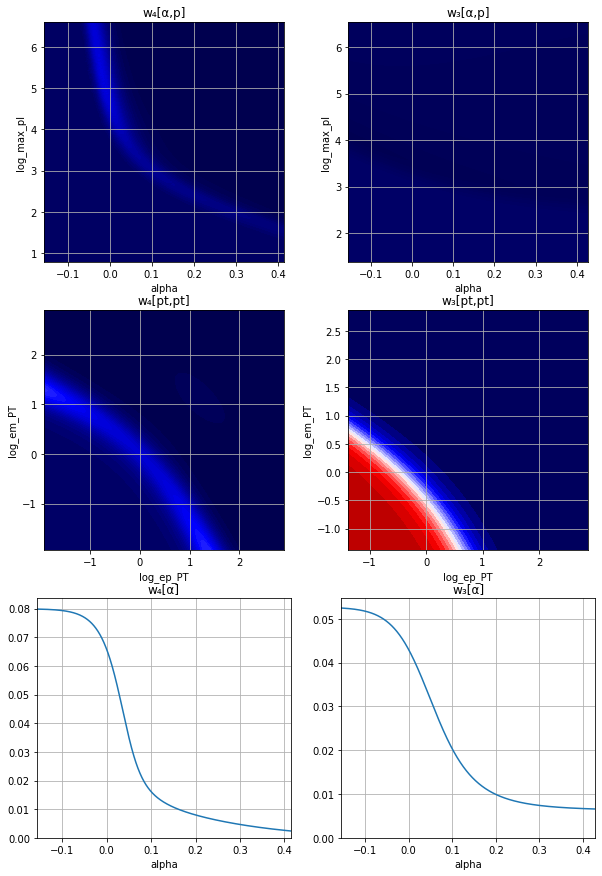

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, d in enumerate([w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3]):
    sc = d.model[0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i//2,i%2], color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i//2,i%2], vmax=None)
plt.show()

In [71]:
def quality(datasets, estimators, refname, name):
    df_w = pd.DataFrame()
    for w in estimators:
        name1 = "1-%s" % w.name
        r_name = "R[%s]" % w.name
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),name1] = 1-torch.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    df_w.columns.name = name
    return df_w

In [72]:
quality(train_ds, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "train")

train           1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.940174    1.04236  0.978445   1.001589    0.950557   
B⁺→K⁺J/ψ(→ee)        0.98        1.0      0.98        1.0        0.98   
B⁺→K⁺ψ(2S)(→ee)  0.986388   0.993524  0.980153   0.999844     0.98547   
D⁺→π⁺φ(→ee)          0.93   1.053763   0.97279   1.007411        0.93   

train           R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.030974     0.92083     1.064257  0.973541  1.006634   
B⁺→K⁺J/ψ(→ee)            1.0        0.98          1.0      0.98       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.994449    0.984248     0.995684  0.981469  0.998503   
D⁺→π⁺φ(→ee)         1.053763    0.540526      1.81305  0.974499  1.005644   

train             1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.975886  1.004216  
B⁺→K⁺J/ψ(→ee)        0.98       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.981029  0.998951  
D⁺→π⁺φ(→ee)      0.976437  1.003649

In [73]:
quality(test_ds, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "test")

test            1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.940269   1.042236  0.978494   1.001534    0.950191   
B⁺→K⁺J/ψ(→ee)    0.979982        1.0  0.979996        1.0    0.979923   
B⁺→K⁺ψ(2S)(→ee)  0.986366   0.993528  0.980132   0.999861    0.985517   
D⁺→π⁺φ(→ee)      0.930137   1.053589  0.972771   1.007427    0.930187   

test            R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.031291    0.919899     1.065291  0.973682  1.006514   
B⁺→K⁺J/ψ(→ee)            1.0    0.979959          1.0  0.980025       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.994324    0.984292     0.995598  0.981427  0.998571   
D⁺→π⁺φ(→ee)         1.053469    0.540022     1.814666  0.974531  1.005638   

test              1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.975972  1.004148  
B⁺→K⁺J/ψ(→ee)    0.980021       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.980994  0.999008  
D⁺→π⁺φ(→ee)      0.976451  1.003656

In [74]:
quality(selected, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "all")

all             1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.940193   1.042335  0.978455   1.001578    0.950484   
B⁺→K⁺J/ψ(→ee)    0.979996        1.0  0.979999        1.0    0.979985   
B⁺→K⁺ψ(2S)(→ee)  0.986384   0.993524  0.980149   0.999847     0.98548   
D⁺→π⁺φ(→ee)      0.930027   1.053729  0.972786   1.007414    0.930037   

all             R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.031038    0.920644     1.064464  0.973569   1.00661   
B⁺→K⁺J/ψ(→ee)            1.0    0.979992          1.0  0.980005       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.994424    0.984257     0.995667   0.98146  0.998517   
D⁺→π⁺φ(→ee)         1.053705    0.540425     1.813373  0.974506  1.005643   

all               1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.975903  1.004203  
B⁺→K⁺J/ψ(→ee)    0.980004       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.981022  0.998962  
D⁺→π⁺φ(→ee)       0.97644  1.003651

### Conditional plots

In [75]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [76]:
def plot_e_all(feature, bins):
    fig, ax = plt.subplots(3, 2, figsize=(10, 15))
    plot_e(w_la4, feature, bins=bins, ax=ax[0,0])
    plot_e(w_la3, feature, bins=bins, ax=ax[0,1])
    plot_e(w_pt4, feature, bins=bins, ax=ax[1,0])
    plot_e(w_pt3, feature, bins=bins, ax=ax[1,1])
    plot_e(w_a4, feature, bins=bins, ax=ax[2,0])
    plot_e(w_a3, feature, bins=bins, ax=ax[2,1])
    plt.show()   

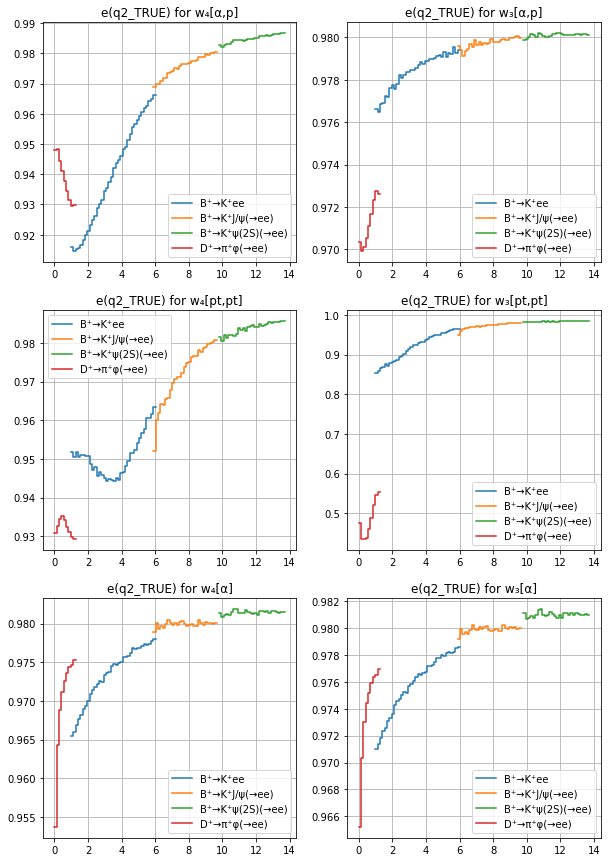

In [77]:
plot_e_all("q2_TRUE", np.linspace(0,14,101))

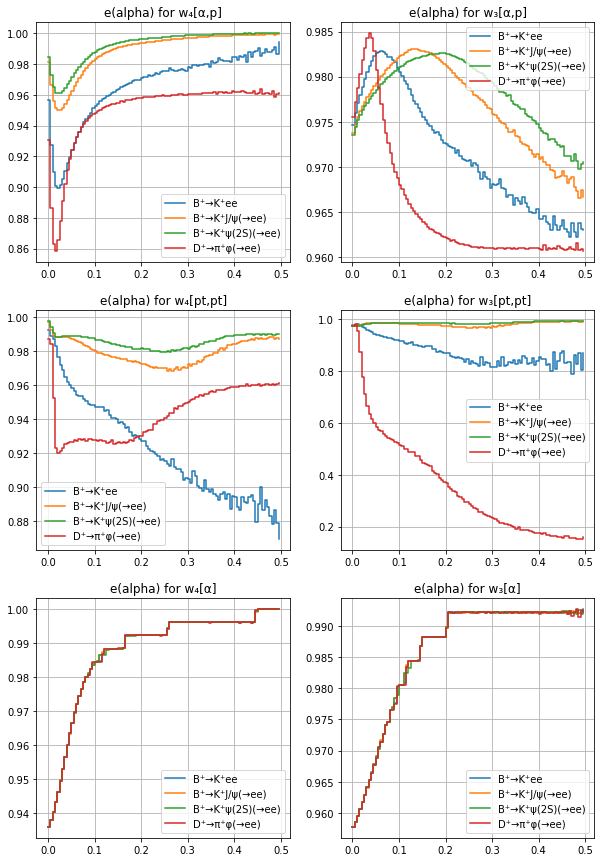

In [78]:
plot_e_all("alpha", np.linspace(0,0.5,101))

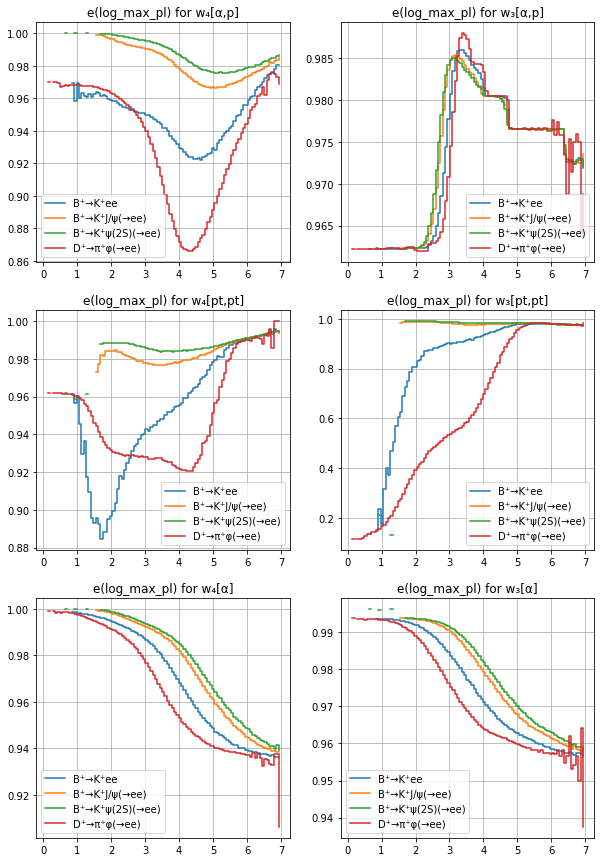

In [79]:
plot_e_all("log_max_pl", np.linspace(0,7,101))

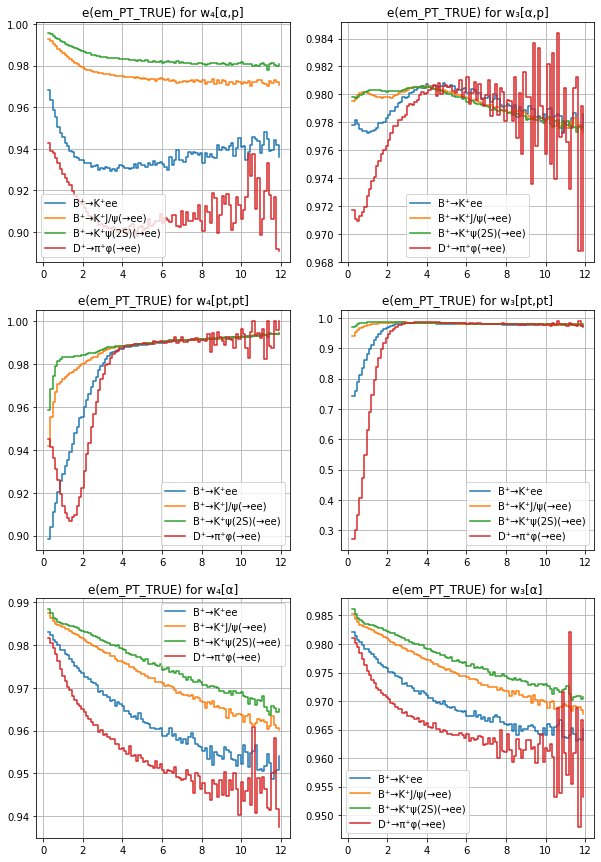

In [80]:
plot_e_all("em_PT_TRUE", np.linspace(0,12,101))

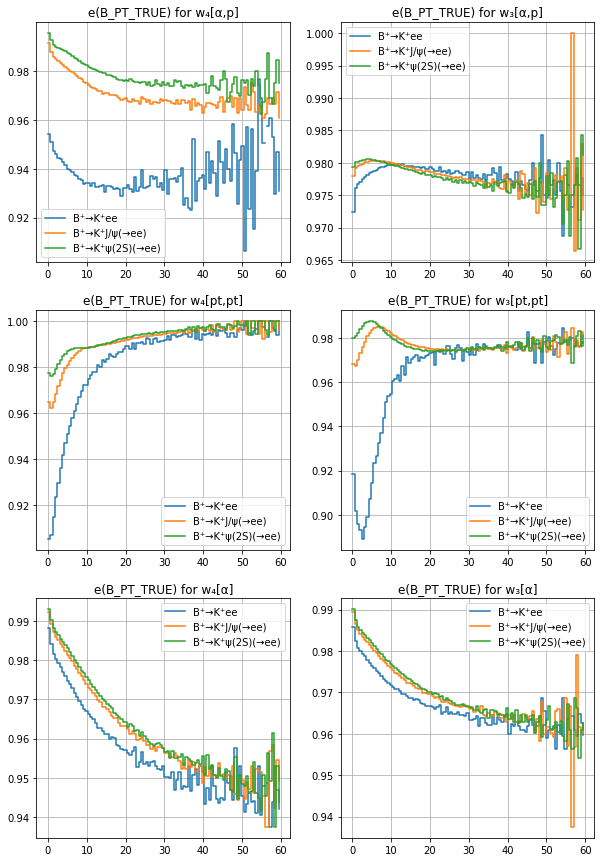

In [81]:
plot_e_all("B_PT_TRUE", np.linspace(0,60,101))

### Base estimators

In [82]:
def show_many(scaler, model, name, by=2, size=5.0):
    import matplotlib.colors
    import matplotlib.cm

    w = as_numpy(model.eval())
    n_inputs = len(scaler.features)
    n_outputs = w(np.zeros((1, n_inputs))).shape[1]
    n2 = (n_outputs + by - 1) // by
    fig, ax = plt.subplots(n2, by, figsize=(by*size, n2*size), sharex=True, sharey=True)
    for i, ax_ in zip(range(n_outputs), ax.flat):
        plot_field(lambda x : w(x)[...,i], scaler, name="%s[%d]"%(name, i), ax=ax_, color_bar=False)
    
    normalizer = matplotlib.colors.Normalize(0, 1)
    im = matplotlib.cm.ScalarMappable(norm=normalizer, cmap=plt.cm.seismic)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.13, 0.02, 0.74]) #lbwh
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [83]:
def show_est(est, name):
    model = est.model.eval()
    scaler = est.scaler
    w = nn.Sequential(model, torch.nn.Softmax(dim=-1))
    show_many(scaler, w, name)

In [84]:
def show_fns(w):
    model = w.model.eval()
    show_many(model[0], model[:-1], w.name)

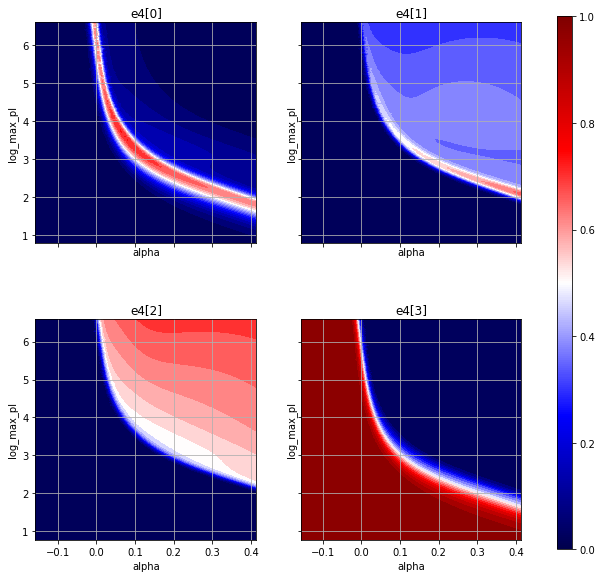

In [85]:
show_est(e_la4, "e4")

In [86]:
show_fns(w_la4)

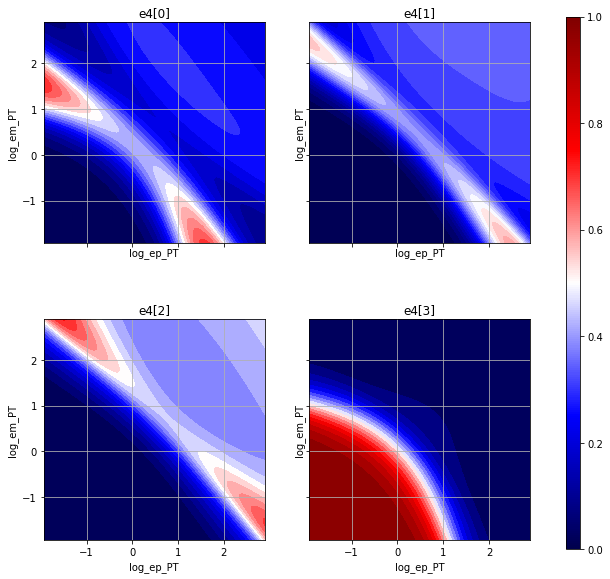

In [87]:
show_est(e_pt4, "e4")

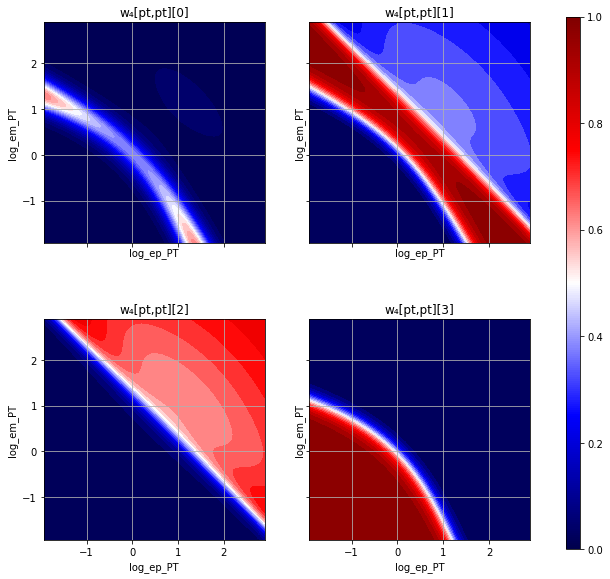

In [88]:
show_fns(w_pt4)

### New stuff

In [89]:
w43 = Weighting(e_la4, n_classes=3, name="w43")
w43.train(ds_la3, target_L=0.1)

Epoch 0 loss=-3.000072 W+c=[ 1.1822 -1.8016  1.1143  2.6788] det=0.000347 L=0.719475
Epoch 1 loss=-3.000071 W+c=[ 1.1826 -1.7977  1.0863  2.6716] det=0.000356 L=0.726645
Epoch 2 loss=-3.000072 W+c=[ 1.1826 -1.7934  1.0593  2.665 ] det=0.000365 L=0.733885
Epoch 3 loss=-3.000072 W+c=[ 1.1822 -1.7889  1.0334  2.6589] det=0.000373 L=0.741191
Epoch 4 loss=-3.000072 W+c=[ 1.1815 -1.7842  1.0086  2.6532] det=0.000382 L=0.748560
Epoch 5 loss=-3.000072 W+c=[ 1.1806 -1.7792  0.9847  2.648 ] det=0.000391 L=0.755990
Epoch 6 loss=-3.000072 W+c=[ 1.1793 -1.774   0.9617  2.6432] det=0.000399 L=0.763480
Epoch 7 loss=-3.000072 W+c=[ 1.1778 -1.7686  0.9397  2.6387] det=0.000408 L=0.771025
Epoch 8 loss=-3.000071 W+c=[ 1.1761 -1.763   0.9185  2.6345] det=0.000416 L=0.778624
Epoch 9 loss=-3.000071 W+c=[ 1.1741 -1.7573  0.8981  2.6307] det=0.000425 L=0.786276
Epoch 10 loss=-3.000072 W+c=[ 1.1719 -1.7513  0.8785  2.6271] det=0.000433 L=0.793977
Epoch 11 loss=-3.000072 W+c=[ 1.1696 -1.7453  0.8596  2.6237] de

Epoch 96 loss=-3.000055 W+c=[ 0.8043 -1.144   0.3054  2.4846] det=0.001022 L=1.469163
Epoch 97 loss=-3.000054 W+c=[ 0.7998 -1.1378  0.3032  2.4827] det=0.001029 L=1.478720
Epoch 98 loss=-3.000054 W+c=[ 0.7954 -1.1316  0.3011  2.4808] det=0.001036 L=1.488351
Epoch 99 loss=-3.000054 W+c=[ 0.7909 -1.1255  0.299   2.4788] det=0.001043 L=1.498059
Epoch 100 loss=-3.000054 W+c=[ 0.7865 -1.1194  0.297   2.4769] det=0.001050 L=1.507839
Epoch 101 loss=-3.000053 W+c=[ 0.7821 -1.1133  0.2949  2.4749] det=0.001057 L=1.517695
Epoch 102 loss=-3.000053 W+c=[ 0.7777 -1.1073  0.293   2.473 ] det=0.001064 L=1.527623
Epoch 103 loss=-3.000053 W+c=[ 0.7733 -1.1013  0.291   2.471 ] det=0.001070 L=1.537624
Epoch 104 loss=-3.000053 W+c=[ 0.7689 -1.0953  0.289   2.469 ] det=0.001077 L=1.547699
Epoch 105 loss=-3.000053 W+c=[ 0.7645 -1.0894  0.2871  2.467 ] det=0.001085 L=1.557846
Epoch 106 loss=-3.000053 W+c=[ 0.7602 -1.0835  0.2853  2.465 ] det=0.001092 L=1.568065
Epoch 107 loss=-3.000052 W+c=[ 0.7558 -1.0777  

Epoch 191 loss=-3.000042 W+c=[ 0.449  -0.7175  0.1893  2.2926] det=0.001803 L=2.576185
Epoch 192 loss=-3.000042 W+c=[ 0.4461 -0.7146  0.1887  2.2908] det=0.001812 L=2.587901
Epoch 193 loss=-3.000042 W+c=[ 0.4434 -0.7118  0.188   2.289 ] det=0.001822 L=2.599574
Epoch 194 loss=-3.000042 W+c=[ 0.4406 -0.709   0.1873  2.2872] det=0.001831 L=2.611207
Epoch 195 loss=-3.000042 W+c=[ 0.4378 -0.7062  0.1867  2.2854] det=0.001841 L=2.622797
Epoch 196 loss=-3.000042 W+c=[ 0.4351 -0.7034  0.186   2.2837] det=0.001850 L=2.634344
Epoch 197 loss=-3.000042 W+c=[ 0.4324 -0.7007  0.1854  2.2819] det=0.001860 L=2.645846
Epoch 198 loss=-3.000041 W+c=[ 0.4297 -0.698   0.1848  2.2802] det=0.001869 L=2.657304
Epoch 199 loss=-3.000041 W+c=[ 0.427  -0.6953  0.1841  2.2784] det=0.001879 L=2.668715
W= [[0.1602 0.0641 0.0267]
 [0.1882 0.3162 0.232 ]
 [0.2011 0.5824 0.7349]
 [0.4504 0.0373 0.0064]]
W+= [[ 0.4244 -0.6927  0.1835  2.2767]
 [ 1.412   7.7411 -2.4727 -2.6329]
 [-1.2919 -5.9306  3.2675  1.4787]]
L= 2.68

Epoch 76 loss=-1.051353 W+c=[ 5.4966 -1.4726  0.718   0.0017] det=0.000096 L=0.774322
Epoch 77 loss=-1.066850 W+c=[ 5.4749 -1.4706  0.7006  0.0017] det=0.000101 L=0.776498
Epoch 78 loss=-1.081344 W+c=[ 5.4546 -1.4682  0.6862  0.0016] det=0.000105 L=0.782492
Epoch 79 loss=-1.093255 W+c=[ 5.4357 -1.4652  0.6743  0.0016] det=0.000109 L=0.788923
Epoch 80 loss=-1.102044 W+c=[ 5.4182 -1.4616  0.6647  0.0015] det=0.000113 L=0.795132
Epoch 81 loss=-1.106945 W+c=[ 5.402  -1.4573  0.6569  0.0015] det=0.000117 L=0.801148
Epoch 82 loss=-1.107540 W+c=[ 5.3871 -1.4522  0.6506  0.0015] det=0.000120 L=0.807149
Epoch 83 loss=-1.103353 W+c=[ 5.3734 -1.4465  0.6458  0.0014] det=0.000123 L=0.813475
Epoch 84 loss=-1.094648 W+c=[ 5.3608 -1.44    0.642   0.0014] det=0.000126 L=0.819600
Epoch 85 loss=-1.081167 W+c=[ 5.3494 -1.4328  0.6392  0.0014] det=0.000128 L=0.825548
Epoch 86 loss=-1.062929 W+c=[ 5.339  -1.425   0.6373  0.0013] det=0.000130 L=0.831336
Epoch 87 loss=-1.039862 W+c=[ 5.3297 -1.4166  0.636   

Epoch 172 loss=0.528343 W+c=[ 6.574  -0.8574  0.5583  0.0009] det=0.000120 L=1.076681
Epoch 173 loss=0.515153 W+c=[ 6.6009 -0.8551  0.5586  0.0009] det=0.000119 L=1.078954
Epoch 174 loss=0.501713 W+c=[ 6.6279 -0.8528  0.5589  0.0009] det=0.000118 L=1.081107
Epoch 175 loss=0.488046 W+c=[ 6.655  -0.8506  0.5592  0.0009] det=0.000117 L=1.083132
Epoch 176 loss=0.474453 W+c=[ 6.6823 -0.8483  0.5596  0.0009] det=0.000117 L=1.085058
Epoch 177 loss=0.460630 W+c=[ 6.7097 -0.8461  0.56    0.0009] det=0.000116 L=1.086865
Epoch 178 loss=0.446847 W+c=[ 6.7372 -0.844   0.5604  0.0009] det=0.000115 L=1.088569
Epoch 179 loss=0.432922 W+c=[ 6.7648 -0.8418  0.5609  0.001 ] det=0.000115 L=1.090169
Epoch 180 loss=0.418717 W+c=[ 6.7925 -0.8397  0.5614  0.001 ] det=0.000114 L=1.091657
Epoch 181 loss=0.404518 W+c=[ 6.8204 -0.8376  0.5619  0.001 ] det=0.000113 L=1.094320
Epoch 182 loss=0.390215 W+c=[ 6.8484 -0.8355  0.5624  0.001 ] det=0.000113 L=1.097041
Epoch 183 loss=0.376006 W+c=[ 6.8764 -0.8334  0.563   

Epoch 267 loss=-0.691943 W+c=[ 9.6837 -0.6861  0.6297  0.0011] det=0.000063 L=1.476837
Epoch 268 loss=-0.700532 W+c=[ 9.7262 -0.6844  0.6301  0.0011] det=0.000063 L=1.485426
Epoch 269 loss=-0.709036 W+c=[ 9.769  -0.6827  0.6305  0.0011] det=0.000062 L=1.493663
Epoch 270 loss=-0.717434 W+c=[ 9.8122 -0.681   0.6309  0.0011] det=0.000062 L=1.501565
Epoch 271 loss=-0.725729 W+c=[ 9.8557 -0.6793  0.6313  0.0011] det=0.000061 L=1.509105
Epoch 272 loss=-0.733856 W+c=[ 9.8994 -0.6776  0.6316  0.0011] det=0.000061 L=1.516840
Epoch 273 loss=-0.741891 W+c=[ 9.9436 -0.6759  0.6319  0.0011] det=0.000061 L=1.525768
Epoch 274 loss=-0.749682 W+c=[ 9.988  -0.6742  0.6322  0.0011] det=0.000060 L=1.534356
Epoch 275 loss=-0.757396 W+c=[10.0328 -0.6725  0.6325  0.0011] det=0.000060 L=1.545680
Epoch 276 loss=-0.764984 W+c=[10.078  -0.6708  0.6328  0.0011] det=0.000059 L=1.556598
Epoch 277 loss=-0.772429 W+c=[10.1234 -0.6691  0.633   0.0011] det=0.000059 L=1.567103
Epoch 278 loss=-0.779714 W+c=[10.1693 -0.66

Epoch 362 loss=-3.022210 W+c=[13.5367 -0.4568  0.4119  0.0012] det=0.000047 L=1.713800
Epoch 363 loss=-3.035063 W+c=[13.561  -0.4548  0.4092  0.0012] det=0.000047 L=1.712674
Epoch 364 loss=-3.047693 W+c=[13.585  -0.4528  0.4065  0.0012] det=0.000047 L=1.711438
Epoch 365 loss=-3.060074 W+c=[13.6087 -0.4509  0.404   0.0012] det=0.000047 L=1.710086
Epoch 366 loss=-3.072237 W+c=[13.6321 -0.4489  0.4014  0.0012] det=0.000047 L=1.710180
Epoch 367 loss=-3.084144 W+c=[13.655  -0.447   0.3989  0.0012] det=0.000047 L=1.711139
Epoch 368 loss=-3.095837 W+c=[13.6777 -0.4451  0.3964  0.0012] det=0.000047 L=1.711948
Epoch 369 loss=-3.107318 W+c=[13.7001 -0.4432  0.394   0.0012] det=0.000047 L=1.712608
Epoch 370 loss=-3.118572 W+c=[13.7221 -0.4414  0.3916  0.0012] det=0.000047 L=1.713117
Epoch 371 loss=-3.129635 W+c=[13.7438 -0.4395  0.3893  0.0012] det=0.000047 L=1.713495
Epoch 372 loss=-3.140504 W+c=[13.7653 -0.4377  0.387   0.0012] det=0.000047 L=1.713750
Epoch 373 loss=-3.151173 W+c=[13.7864 -0.43

Epoch 457 loss=-3.661516 W+c=[14.8123 -0.3346  0.2751  0.0011] det=0.000052 L=1.656516
Epoch 458 loss=-3.664977 W+c=[14.8186 -0.3338  0.2744  0.001 ] det=0.000052 L=1.655769
Epoch 459 loss=-3.668388 W+c=[14.8247 -0.333   0.2736  0.001 ] det=0.000052 L=1.654992
Epoch 460 loss=-3.671765 W+c=[14.8308 -0.3322  0.2729  0.001 ] det=0.000052 L=1.654188
Epoch 461 loss=-3.675102 W+c=[14.8368 -0.3314  0.2722  0.001 ] det=0.000052 L=1.653363
Epoch 462 loss=-3.678398 W+c=[14.8426 -0.3306  0.2716  0.001 ] det=0.000052 L=1.652509
Epoch 463 loss=-3.681661 W+c=[14.8484 -0.3298  0.2709  0.001 ] det=0.000053 L=1.651639
Epoch 464 loss=-3.684883 W+c=[14.8541 -0.329   0.2702  0.001 ] det=0.000053 L=1.650739
Epoch 465 loss=-3.688083 W+c=[14.8597 -0.3282  0.2695  0.001 ] det=0.000053 L=1.649821
Epoch 466 loss=-3.691232 W+c=[14.8652 -0.3275  0.2689  0.001 ] det=0.000053 L=1.648883
Epoch 467 loss=-3.694340 W+c=[14.8706 -0.3267  0.2682  0.001 ] det=0.000053 L=1.647917
Epoch 468 loss=-3.697427 W+c=[14.876  -0.32

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [90]:
w43pt = Weighting(e_pt4, n_classes=3, name="w43pt")
w43pt.train(ds_pt3, target_L=0.1)

Epoch 0 loss=-3.000039 W+c=[ 1.1535 -5.5416  2.9182  6.759 ] det=0.000014 L=0.060485
Epoch 1 loss=-3.000042 W+c=[ 1.1464 -5.5065  2.8996  6.7457] det=0.000014 L=0.060899
Epoch 2 loss=-3.000041 W+c=[ 1.139  -5.4718  2.8813  6.7326] det=0.000014 L=0.061321
Epoch 3 loss=-3.000041 W+c=[ 1.1315 -5.4375  2.8633  6.7196] det=0.000014 L=0.061751
Epoch 4 loss=-3.000041 W+c=[ 1.1239 -5.4036  2.8456  6.7067] det=0.000014 L=0.062188
Epoch 5 loss=-3.000041 W+c=[ 1.116  -5.3701  2.8282  6.6939] det=0.000015 L=0.062635
Epoch 6 loss=-3.000043 W+c=[ 1.1081 -5.337   2.811   6.6812] det=0.000015 L=0.063089
Epoch 7 loss=-3.000041 W+c=[ 1.1    -5.3042  2.7942  6.6686] det=0.000015 L=0.063551
Epoch 8 loss=-3.000041 W+c=[ 1.0917 -5.2718  2.7776  6.656 ] det=0.000015 L=0.064022
Epoch 9 loss=-3.000041 W+c=[ 1.0833 -5.2397  2.7613  6.6435] det=0.000015 L=0.064501
Epoch 10 loss=-3.000042 W+c=[ 1.0748 -5.2081  2.7453  6.6312] det=0.000015 L=0.064989
Epoch 11 loss=-3.000042 W+c=[ 1.0662 -5.1768  2.7295  6.6188] de

Epoch 96 loss=-3.000042 W+c=[ 0.4118 -3.544   1.9601  5.7418] det=0.000036 L=0.128020
Epoch 97 loss=-3.000041 W+c=[ 0.4072 -3.5333  1.9547  5.734 ] det=0.000036 L=0.128851
Epoch 98 loss=-3.000041 W+c=[ 0.4027 -3.5229  1.9494  5.7263] det=0.000036 L=0.129684
Epoch 99 loss=-3.000041 W+c=[ 0.3982 -3.5125  1.9442  5.7187] det=0.000037 L=0.130518
Epoch 100 loss=-3.000041 W+c=[ 0.3938 -3.5023  1.939   5.7111] det=0.000037 L=0.131352
Epoch 101 loss=-3.000041 W+c=[ 0.3895 -3.4921  1.9338  5.7036] det=0.000037 L=0.132188
Epoch 102 loss=-3.000041 W+c=[ 0.3852 -3.4821  1.9287  5.6962] det=0.000038 L=0.133024
Epoch 103 loss=-3.000041 W+c=[ 0.381  -3.4722  1.9236  5.6888] det=0.000038 L=0.133861
Epoch 104 loss=-3.000041 W+c=[ 0.3769 -3.4625  1.9186  5.6815] det=0.000038 L=0.134701
Epoch 105 loss=-3.000041 W+c=[ 0.3728 -3.4528  1.9136  5.6743] det=0.000038 L=0.135542
Epoch 106 loss=-3.000042 W+c=[ 0.3688 -3.4432  1.9086  5.6671] det=0.000039 L=0.136384
Epoch 107 loss=-3.000042 W+c=[ 0.3649 -3.4338  

Epoch 191 loss=-3.000045 W+c=[ 0.1697 -2.9064  1.5847  5.25  ] det=0.000066 L=0.189337
Epoch 192 loss=-3.000044 W+c=[ 0.1683 -2.9022  1.5818  5.2468] det=0.000066 L=0.189755
Epoch 193 loss=-3.000044 W+c=[ 0.167  -2.8981  1.5788  5.2435] det=0.000066 L=0.190170
Epoch 194 loss=-3.000045 W+c=[ 0.1657 -2.8941  1.5758  5.2403] det=0.000067 L=0.190581
Epoch 195 loss=-3.000045 W+c=[ 0.1643 -2.89    1.5729  5.2372] det=0.000067 L=0.190987
Epoch 196 loss=-3.000044 W+c=[ 0.163  -2.886   1.5699  5.234 ] det=0.000067 L=0.191390
Epoch 197 loss=-3.000044 W+c=[ 0.1618 -2.8821  1.567   5.2309] det=0.000068 L=0.191789
Epoch 198 loss=-3.000044 W+c=[ 0.1605 -2.8781  1.5641  5.2278] det=0.000068 L=0.192184
Epoch 199 loss=-3.000044 W+c=[ 0.1592 -2.8742  1.5612  5.2247] det=0.000068 L=0.192575
W= [[0.137  0.1505 0.1517]
 [0.3229 0.3985 0.3637]
 [0.2496 0.3371 0.4124]
 [0.2904 0.1139 0.0722]]
W+= [[  0.158   -2.8703   1.5583   5.2216]
 [  0.4161  12.6743 -10.3898  -5.3596]
 [ -0.063   -8.7015   9.9127   1.18

Epoch 83 loss=-5.098832 W+c=[ 0.4752 -0.803   0.3767 14.0072] det=0.000025 L=0.876507
Epoch 84 loss=-5.070787 W+c=[ 0.4742 -0.8006  0.3741 14.0755] det=0.000024 L=0.882226
Epoch 85 loss=-5.043155 W+c=[ 0.4733 -0.7983  0.3715 14.144 ] det=0.000024 L=0.887842
Epoch 86 loss=-5.015960 W+c=[ 0.4724 -0.7961  0.3688 14.2126] det=0.000024 L=0.893350
Epoch 87 loss=-4.989190 W+c=[ 0.4716 -0.7938  0.3661 14.2815] det=0.000024 L=0.898752
Epoch 88 loss=-4.962858 W+c=[ 0.4707 -0.7917  0.3635 14.3506] det=0.000024 L=0.904043
Epoch 89 loss=-4.936941 W+c=[ 0.4699 -0.7896  0.3608 14.4198] det=0.000024 L=0.909225
Epoch 90 loss=-4.911443 W+c=[ 0.4692 -0.7875  0.3582 14.4892] det=0.000023 L=0.914300
Epoch 91 loss=-4.886372 W+c=[ 0.4684 -0.7855  0.3555 14.5587] det=0.000023 L=0.919261
Epoch 92 loss=-4.861712 W+c=[ 0.4677 -0.7835  0.3528 14.6282] det=0.000023 L=0.924110
Epoch 93 loss=-4.837484 W+c=[ 0.4671 -0.7816  0.3502 14.6979] det=0.000023 L=0.928847
Epoch 94 loss=-4.813675 W+c=[ 0.4664 -0.7797  0.3475 1

Epoch 178 loss=-3.924334 W+c=[ 0.4759 -0.7194  0.1922 19.0849] det=0.000017 L=1.173903
Epoch 179 loss=-3.921635 W+c=[ 0.4765 -0.7194  0.1913 19.1092] det=0.000017 L=1.175075
Epoch 180 loss=-3.919033 W+c=[ 0.4771 -0.7193  0.1904 19.133 ] det=0.000017 L=1.176216
Epoch 181 loss=-3.916502 W+c=[ 0.4778 -0.7192  0.1895 19.1564] det=0.000017 L=1.177327
Epoch 182 loss=-3.914039 W+c=[ 0.4785 -0.7192  0.1886 19.1791] det=0.000017 L=1.178409
Epoch 183 loss=-3.911650 W+c=[ 0.4791 -0.7191  0.1877 19.2014] det=0.000017 L=1.179461
Epoch 184 loss=-3.909337 W+c=[ 0.4798 -0.7191  0.1869 19.2232] det=0.000017 L=1.180486
Epoch 185 loss=-3.907086 W+c=[ 0.4805 -0.719   0.186  19.2445] det=0.000017 L=1.181488
Epoch 186 loss=-3.904901 W+c=[ 0.4812 -0.719   0.1852 19.2653] det=0.000017 L=1.182462
Epoch 187 loss=-3.902785 W+c=[ 0.4818 -0.719   0.1844 19.2858] det=0.000017 L=1.183410
Epoch 188 loss=-3.900736 W+c=[ 0.4825 -0.7189  0.1836 19.3056] det=0.000017 L=1.184334
Epoch 189 loss=-3.898728 W+c=[ 0.4832 -0.71

Epoch 273 loss=-3.917010 W+c=[ 0.5371 -0.723   0.1555 19.5978] det=0.000020 L=1.191990
Epoch 274 loss=-3.917634 W+c=[ 0.5375 -0.723   0.1554 19.5951] det=0.000020 L=1.191847
Epoch 275 loss=-3.918220 W+c=[ 0.5379 -0.723   0.1553 19.5924] det=0.000020 L=1.191705
Epoch 276 loss=-3.918843 W+c=[ 0.5383 -0.7231  0.1552 19.5897] det=0.000020 L=1.191562
Epoch 277 loss=-3.919442 W+c=[ 0.5387 -0.7231  0.1551 19.587 ] det=0.000020 L=1.191420
Epoch 278 loss=-3.920032 W+c=[ 0.5391 -0.7231  0.155  19.5843] det=0.000020 L=1.191278
Epoch 279 loss=-3.920630 W+c=[ 0.5395 -0.7231  0.1549 19.5817] det=0.000020 L=1.191136
Epoch 280 loss=-3.921213 W+c=[ 0.5399 -0.7231  0.1548 19.5791] det=0.000020 L=1.190995
Epoch 281 loss=-3.921803 W+c=[ 0.5403 -0.7231  0.1547 19.5765] det=0.000020 L=1.190854
Epoch 282 loss=-3.922393 W+c=[ 0.5406 -0.7232  0.1546 19.5739] det=0.000020 L=1.190713
Epoch 283 loss=-3.922965 W+c=[ 0.541  -0.7232  0.1545 19.5713] det=0.000020 L=1.190573
Epoch 284 loss=-3.923557 W+c=[ 0.5414 -0.72

Epoch 368 loss=-3.962635 W+c=[ 0.5538 -0.7206  0.15   19.3943] det=0.000024 L=1.179630
Epoch 369 loss=-3.963023 W+c=[ 0.5538 -0.7205  0.1499 19.3926] det=0.000024 L=1.179511
Epoch 370 loss=-3.963395 W+c=[ 0.5538 -0.7205  0.1499 19.3909] det=0.000024 L=1.179392
Epoch 371 loss=-3.963772 W+c=[ 0.5537 -0.7204  0.1499 19.3892] det=0.000024 L=1.179274
Epoch 372 loss=-3.964148 W+c=[ 0.5537 -0.7203  0.1499 19.3875] det=0.000024 L=1.179156
Epoch 373 loss=-3.964509 W+c=[ 0.5536 -0.7203  0.1498 19.3858] det=0.000024 L=1.179037
Epoch 374 loss=-3.964887 W+c=[ 0.5536 -0.7202  0.1498 19.3842] det=0.000024 L=1.178919
Epoch 375 loss=-3.965248 W+c=[ 0.5535 -0.7201  0.1498 19.3825] det=0.000024 L=1.178801
Epoch 376 loss=-3.965609 W+c=[ 0.5534 -0.7201  0.1498 19.3808] det=0.000024 L=1.178684
Epoch 377 loss=-3.965987 W+c=[ 0.5534 -0.72    0.1497 19.3792] det=0.000024 L=1.178566
Epoch 378 loss=-3.966361 W+c=[ 0.5533 -0.7199  0.1497 19.3776] det=0.000024 L=1.178448
Epoch 379 loss=-3.966713 W+c=[ 0.5532 -0.71

Epoch 463 loss=-3.993163 W+c=[ 0.5362 -0.7122  0.1493 19.2555] det=0.000027 L=1.169038
Epoch 464 loss=-3.993449 W+c=[ 0.5359 -0.7121  0.1493 19.2542] det=0.000027 L=1.168933
Epoch 465 loss=-3.993721 W+c=[ 0.5356 -0.712   0.1493 19.2529] det=0.000027 L=1.168828
Epoch 466 loss=-3.993997 W+c=[ 0.5353 -0.7119  0.1493 19.2516] det=0.000027 L=1.168723
Epoch 467 loss=-3.994276 W+c=[ 0.535  -0.7118  0.1493 19.2504] det=0.000027 L=1.168619
Epoch 468 loss=-3.994552 W+c=[ 0.5347 -0.7117  0.1493 19.2491] det=0.000027 L=1.168513
Epoch 469 loss=-3.994818 W+c=[ 0.5344 -0.7116  0.1493 19.2478] det=0.000027 L=1.168410
Epoch 470 loss=-3.995103 W+c=[ 0.534  -0.7115  0.1493 19.2465] det=0.000028 L=1.168305
Epoch 471 loss=-3.995373 W+c=[ 0.5337 -0.7114  0.1493 19.2452] det=0.000028 L=1.168200
Epoch 472 loss=-3.995646 W+c=[ 0.5334 -0.7113  0.1493 19.244 ] det=0.000028 L=1.168097
Epoch 473 loss=-3.995922 W+c=[ 0.5331 -0.7112  0.1493 19.2427] det=0.000028 L=1.167992
Epoch 474 loss=-3.996202 W+c=[ 0.5327 -0.71

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, d in enumerate([w43, w43pt]):
    sc = d.model[0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i], color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i], vmax=None)
plt.show()

In [92]:
quality(train_ds, [w_la3, w43, w_pt3, w43pt], channel_names[1], "train")

train           1-w₃[α,p] R[w₃[α,p]]     1-w43    R[w43] 1-w₃[pt,pt]  \
B⁺→K⁺ee          0.978445   1.001589  0.902748  1.085574     0.92083   
B⁺→K⁺J/ψ(→ee)        0.98        1.0      0.98       1.0        0.98   
B⁺→K⁺ψ(2S)(→ee)  0.980153   0.999844  0.986393  0.993518    0.984248   
D⁺→π⁺φ(→ee)       0.97279   1.007411  0.664151  1.475568    0.540526   

train           R[w₃[pt,pt]]   1-w43pt  R[w43pt]  
B⁺→K⁺ee             1.064257  0.925479  1.058911  
B⁺→K⁺J/ψ(→ee)            1.0      0.98       1.0  
B⁺→K⁺ψ(2S)(→ee)     0.995684  0.985353  0.994568  
D⁺→π⁺φ(→ee)          1.81305  0.524415  1.868749

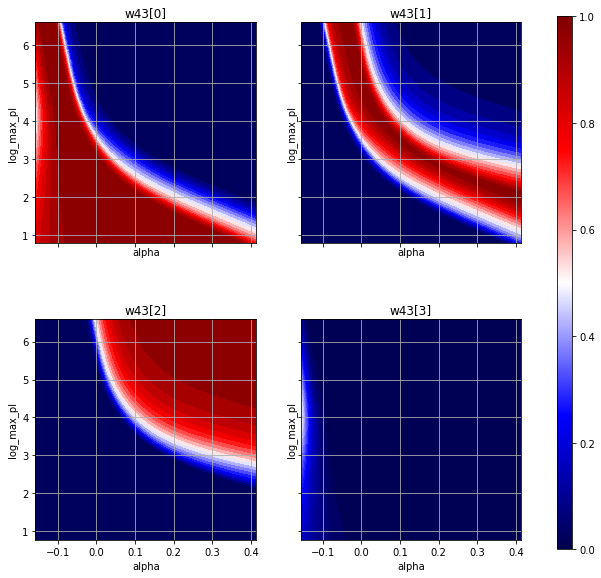

In [93]:
show_fns(w43)
show_fns(w43pt)

In [94]:
ds_apt = Dataset(["alpha", "log_ep_PT", "log_em_PT"], train_ds, aliases, "₄[α,pt,pt]")

In [95]:
e_apt = Estimator(ds_apt)
e_apt.train(ds_apt)

INFO:root:Epoch 0, 1.413790
INFO:root:Epoch 1, 1.376480
INFO:root:Epoch 2, 1.355320
INFO:root:Epoch 3, 1.306274
INFO:root:Epoch 4, 1.211549
INFO:root:Epoch 5, 1.103763
INFO:root:Epoch 6, 1.043790
INFO:root:Epoch 7, 1.028504
INFO:root:Epoch 8, 1.020481
INFO:root:Epoch 9, 1.012717
INFO:root:Epoch 10, 1.004688
INFO:root:Epoch 11, 0.996039
INFO:root:Epoch 12, 0.986864
INFO:root:Epoch 13, 0.977995
INFO:root:Epoch 14, 0.971026
INFO:root:Epoch 15, 0.966751
INFO:root:Epoch 16, 0.964790
INFO:root:Epoch 17, 0.963744
INFO:root:Epoch 18, 0.963275
INFO:root:Epoch 19, 0.962948
INFO:root:Epoch 20, 0.962560
INFO:root:Epoch 21, 0.962270
INFO:root:Epoch 22, 0.962069
INFO:root:Epoch 23, 0.961799
INFO:root:Epoch 24, 0.961576
INFO:root:Epoch 25, 0.961316
INFO:root:Epoch 26, 0.961089
INFO:root:Epoch 27, 0.960846
INFO:root:Epoch 28, 0.960661
INFO:root:Epoch 29, 0.960433
INFO:root:Epoch 30, 0.960234
INFO:root:Epoch 31, 0.960003
INFO:root:Epoch 32, 0.959822
INFO:root:Epoch 33, 0.959641
INFO:root:Epoch 34, 0.95

Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [96]:
w_apt = Weighting(e_apt, name="w_apt")
w_apt.train(ds_apt, target_L=0.1)

Epoch 0 loss=-4.000034 W+c=[ 11.5308 -14.4012   6.2921  -2.4999] det=0.000002 L=0.072587
Epoch 1 loss=-4.000031 W+c=[ 11.5135 -14.3859   6.2593  -2.5025] det=0.000002 L=0.072553
Epoch 2 loss=-4.000031 W+c=[ 11.4963 -14.3705   6.2272  -2.505 ] det=0.000002 L=0.072520
Epoch 3 loss=-4.000032 W+c=[ 11.4792 -14.355    6.1955  -2.5075] det=0.000003 L=0.072488
Epoch 4 loss=-4.000032 W+c=[ 11.4623 -14.3392   6.1644  -2.5101] det=0.000003 L=0.072456
Epoch 5 loss=-4.000031 W+c=[ 11.4454 -14.3232   6.1337  -2.5125] det=0.000003 L=0.072424
Epoch 6 loss=-4.000033 W+c=[ 11.4287 -14.3071   6.1035  -2.515 ] det=0.000003 L=0.072393
Epoch 7 loss=-4.000029 W+c=[ 11.412  -14.2908   6.0738  -2.5174] det=0.000003 L=0.072363
Epoch 8 loss=-4.000032 W+c=[ 11.3955 -14.2744   6.0445  -2.5199] det=0.000003 L=0.072332
Epoch 9 loss=-4.000033 W+c=[ 11.3791 -14.2578   6.0157  -2.5223] det=0.000003 L=0.072303
Epoch 10 loss=-4.000033 W+c=[ 11.3628 -14.2411   5.9873  -2.5247] det=0.000003 L=0.072273
Epoch 11 loss=-4.000

Epoch 92 loss=-4.000037 W+c=[ 10.3215 -12.7152   4.4976  -2.6773] det=0.000004 L=0.070901
Epoch 93 loss=-4.000037 W+c=[ 10.3117 -12.6973   4.4854  -2.6787] det=0.000004 L=0.070894
Epoch 94 loss=-4.000037 W+c=[ 10.3019 -12.6794   4.4733  -2.6801] det=0.000004 L=0.070887
Epoch 95 loss=-4.000036 W+c=[ 10.2922 -12.6616   4.4613  -2.6815] det=0.000004 L=0.070880
Epoch 96 loss=-4.000038 W+c=[ 10.2826 -12.6438   4.4494  -2.6829] det=0.000004 L=0.070873
Epoch 97 loss=-4.000038 W+c=[ 10.273  -12.6261   4.4376  -2.6843] det=0.000004 L=0.070866
Epoch 98 loss=-4.000037 W+c=[ 10.2634 -12.6084   4.4258  -2.6856] det=0.000004 L=0.070859
Epoch 99 loss=-4.000036 W+c=[ 10.2539 -12.5908   4.4141  -2.687 ] det=0.000004 L=0.070853
Epoch 100 loss=-4.000037 W+c=[ 10.2445 -12.5733   4.4025  -2.6883] det=0.000004 L=0.070847
Epoch 101 loss=-4.000040 W+c=[ 10.2351 -12.5558   4.391   -2.6897] det=0.000004 L=0.070841
Epoch 102 loss=-4.000036 W+c=[ 10.2257 -12.5383   4.3796  -2.691 ] det=0.000004 L=0.070835
Epoch 1

Epoch 183 loss=-4.000041 W+c=[  9.6025 -11.3065   3.6452  -2.7724] det=0.000005 L=0.070945
Epoch 184 loss=-4.000041 W+c=[  9.5962 -11.2935   3.638   -2.7731] det=0.000005 L=0.070949
Epoch 185 loss=-4.000043 W+c=[  9.5898 -11.2805   3.6307  -2.7738] det=0.000005 L=0.070954
Epoch 186 loss=-4.000043 W+c=[  9.5835 -11.2676   3.6235  -2.7745] det=0.000005 L=0.070958
Epoch 187 loss=-4.000041 W+c=[  9.5772 -11.2548   3.6164  -2.7752] det=0.000005 L=0.070962
Epoch 188 loss=-4.000042 W+c=[  9.5709 -11.2419   3.6092  -2.7759] det=0.000005 L=0.070967
Epoch 189 loss=-4.000043 W+c=[  9.5646 -11.2292   3.6021  -2.7766] det=0.000005 L=0.070972
Epoch 190 loss=-4.000041 W+c=[  9.5584 -11.2165   3.5951  -2.7773] det=0.000006 L=0.070976
Epoch 191 loss=-4.000045 W+c=[  9.5522 -11.2038   3.588   -2.778 ] det=0.000006 L=0.070981
Epoch 192 loss=-4.000042 W+c=[  9.546  -11.1912   3.581   -2.7786] det=0.000006 L=0.070986
Epoch 193 loss=-4.000045 W+c=[  9.5399 -11.1786   3.5741  -2.7793] det=0.000006 L=0.070990

Epoch 73 loss=-14.087605 W+c=[15.1188 -5.0321  5.3277 -2.5404] det=0.000004 L=0.177923
Epoch 74 loss=-14.093969 W+c=[15.1144 -5.0197  5.3076 -2.5376] det=0.000004 L=0.178327
Epoch 75 loss=-14.100605 W+c=[15.1094 -5.0074  5.2877 -2.5348] det=0.000004 L=0.178725
Epoch 76 loss=-14.107511 W+c=[15.1041 -4.9953  5.2681 -2.5321] det=0.000004 L=0.179115
Epoch 77 loss=-14.114661 W+c=[15.0983 -4.9832  5.2487 -2.5294] det=0.000004 L=0.179499
Epoch 78 loss=-14.122044 W+c=[15.092  -4.9713  5.2296 -2.5267] det=0.000004 L=0.179876
Epoch 79 loss=-14.129666 W+c=[15.0854 -4.9594  5.2107 -2.5241] det=0.000004 L=0.180246
Epoch 80 loss=-14.137502 W+c=[15.0784 -4.9477  5.1921 -2.5215] det=0.000004 L=0.180611
Epoch 81 loss=-14.145552 W+c=[15.071  -4.9361  5.1737 -2.5189] det=0.000004 L=0.180969
Epoch 82 loss=-14.153811 W+c=[15.0633 -4.9246  5.1555 -2.5163] det=0.000004 L=0.181321
Epoch 83 loss=-14.162261 W+c=[15.0552 -4.9132  5.1376 -2.5137] det=0.000004 L=0.181667
Epoch 84 loss=-14.170894 W+c=[15.0468 -4.90

Epoch 167 loss=-15.125700 W+c=[13.934  -4.1762  4.1399 -2.353 ] det=0.000006 L=0.221612
Epoch 168 loss=-15.137520 W+c=[13.92   -4.1691  4.1314 -2.3515] det=0.000006 L=0.222102
Epoch 169 loss=-15.149314 W+c=[13.9059 -4.1621  4.1229 -2.3501] det=0.000006 L=0.222591
Epoch 170 loss=-15.161068 W+c=[13.8919 -4.1551  4.1144 -2.3487] det=0.000006 L=0.223078
Epoch 171 loss=-15.172821 W+c=[13.878  -4.1481  4.106  -2.3473] det=0.000006 L=0.223562
Epoch 172 loss=-15.184546 W+c=[13.8641 -4.1411  4.0976 -2.3459] det=0.000006 L=0.224045
Epoch 173 loss=-15.196230 W+c=[13.8502 -4.1342  4.0893 -2.3445] det=0.000006 L=0.224525
Epoch 174 loss=-15.207911 W+c=[13.8363 -4.1272  4.081  -2.3431] det=0.000006 L=0.225003
Epoch 175 loss=-15.219542 W+c=[13.8225 -4.1203  4.0727 -2.3417] det=0.000006 L=0.225479
Epoch 176 loss=-15.231146 W+c=[13.8088 -4.1135  4.0645 -2.3403] det=0.000006 L=0.225953
Epoch 177 loss=-15.242726 W+c=[13.795  -4.1066  4.0563 -2.339 ] det=0.000006 L=0.226424
Epoch 178 loss=-15.254281 W+c=[1

Epoch 261 loss=-16.065506 W+c=[12.8212 -3.5985  3.4438 -2.2513] det=0.000009 L=0.281777
Epoch 262 loss=-16.072983 W+c=[12.8121 -3.5931  3.4371 -2.2505] det=0.000009 L=0.282708
Epoch 263 loss=-16.080391 W+c=[12.803  -3.5877  3.4304 -2.2498] det=0.000009 L=0.283639
Epoch 264 loss=-16.087740 W+c=[12.794  -3.5822  3.4237 -2.249 ] det=0.000009 L=0.284568
Epoch 265 loss=-16.095005 W+c=[12.7851 -3.5769  3.417  -2.2482] det=0.000009 L=0.285495
Epoch 266 loss=-16.102228 W+c=[12.7763 -3.5715  3.4103 -2.2474] det=0.000009 L=0.286421
Epoch 267 loss=-16.109360 W+c=[12.7675 -3.5661  3.4036 -2.2467] det=0.000009 L=0.287345
Epoch 268 loss=-16.116434 W+c=[12.7587 -3.5607  3.3969 -2.2459] det=0.000009 L=0.288268
Epoch 269 loss=-16.123440 W+c=[12.7501 -3.5554  3.3902 -2.2452] det=0.000009 L=0.289189
Epoch 270 loss=-16.130363 W+c=[12.7415 -3.5501  3.3836 -2.2444] det=0.000009 L=0.290107
Epoch 271 loss=-16.137220 W+c=[12.733  -3.5447  3.3769 -2.2437] det=0.000009 L=0.291024
Epoch 272 loss=-16.144012 W+c=[1

Epoch 355 loss=-16.407824 W+c=[12.2725 -3.132   2.8359 -2.1957] det=0.000012 L=0.375718
Epoch 356 loss=-16.406723 W+c=[12.2704 -3.1275  2.8296 -2.1953] det=0.000012 L=0.376810
Epoch 357 loss=-16.405506 W+c=[12.2683 -3.1229  2.8233 -2.1948] det=0.000012 L=0.377896
Epoch 358 loss=-16.404165 W+c=[12.2663 -3.1184  2.817  -2.1944] det=0.000012 L=0.378974
Epoch 359 loss=-16.402710 W+c=[12.2644 -3.1139  2.8108 -2.194 ] det=0.000012 L=0.380045
Epoch 360 loss=-16.401134 W+c=[12.2626 -3.1094  2.8045 -2.1936] det=0.000012 L=0.381110
Epoch 361 loss=-16.399427 W+c=[12.2609 -3.1049  2.7982 -2.1932] det=0.000012 L=0.382168
Epoch 362 loss=-16.397610 W+c=[12.2593 -3.1004  2.792  -2.1927] det=0.000012 L=0.383218
Epoch 363 loss=-16.395658 W+c=[12.2577 -3.0959  2.7857 -2.1923] det=0.000012 L=0.384263
Epoch 364 loss=-16.393599 W+c=[12.2563 -3.0914  2.7795 -2.1919] det=0.000012 L=0.385299
Epoch 365 loss=-16.391403 W+c=[12.2549 -3.0869  2.7732 -2.1915] det=0.000012 L=0.386328
Epoch 366 loss=-16.389093 W+c=[1

Epoch 449 loss=-15.717755 W+c=[12.4838 -2.74    2.2598 -2.1669] det=0.000015 L=0.474312
Epoch 450 loss=-15.703389 W+c=[12.4911 -2.7362  2.2538 -2.1667] det=0.000015 L=0.476025
Epoch 451 loss=-15.688880 W+c=[12.4984 -2.7324  2.2479 -2.1665] det=0.000015 L=0.477736
Epoch 452 loss=-15.674219 W+c=[12.5059 -2.7287  2.242  -2.1664] det=0.000015 L=0.479446
Epoch 453 loss=-15.659416 W+c=[12.5135 -2.7249  2.236  -2.1662] det=0.000015 L=0.481155
Epoch 454 loss=-15.644449 W+c=[12.5212 -2.7211  2.2301 -2.1661] det=0.000015 L=0.482863
Epoch 455 loss=-15.629340 W+c=[12.5291 -2.7174  2.2242 -2.1659] det=0.000015 L=0.484570
Epoch 456 loss=-15.614086 W+c=[12.537  -2.7137  2.2183 -2.1658] det=0.000015 L=0.486276
Epoch 457 loss=-15.598675 W+c=[12.5451 -2.7099  2.2124 -2.1656] det=0.000015 L=0.487981
Epoch 458 loss=-15.583117 W+c=[12.5533 -2.7062  2.2065 -2.1655] det=0.000015 L=0.489685
Epoch 459 loss=-15.567414 W+c=[12.5615 -2.7025  2.2006 -2.1653] det=0.000015 L=0.491388
Epoch 460 loss=-15.551557 W+c=[1

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=4, out_features=1, bias=False)
)

In [97]:
quality(train_ds, [w_apt, w_la4, w_pt4], channel_names[1], "train")

train             1-w_apt  R[w_apt] 1-w₄[α,p] R[w₄[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee           0.94808  1.033668  0.940174    1.04236    0.950557   
B⁺→K⁺J/ψ(→ee)        0.98       1.0      0.98        1.0        0.98   
B⁺→K⁺ψ(2S)(→ee)  0.988435  0.991466  0.986388   0.993524     0.98547   
D⁺→π⁺φ(→ee)          0.93  1.053763      0.93   1.053763        0.93   

train           R[w₄[pt,pt]]  
B⁺→K⁺ee             1.030974  
B⁺→K⁺J/ψ(→ee)            1.0  
B⁺→K⁺ψ(2S)(→ee)     0.994449  
D⁺→π⁺φ(→ee)         1.053763

In [98]:
quality(test_ds, [w_apt, w_la4, w_pt4], channel_names[1], "test")

test              1-w_apt  R[w_apt] 1-w₄[α,p] R[w₄[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.947884  1.033824  0.940269   1.042236    0.950191   
B⁺→K⁺J/ψ(→ee)    0.979945       1.0  0.979982        1.0    0.979923   
B⁺→K⁺ψ(2S)(→ee)   0.98847  0.991376  0.986366   0.993528    0.985517   
D⁺→π⁺φ(→ee)      0.930129  1.053559  0.930137   1.053589    0.930187   

test            R[w₄[pt,pt]]  
B⁺→K⁺ee             1.031291  
B⁺→K⁺J/ψ(→ee)            1.0  
B⁺→K⁺ψ(2S)(→ee)     0.994324  
D⁺→π⁺φ(→ee)         1.053469

In [99]:
e10 = Estimator(ds_la4)
e10.model = torch.nn.Sequential(e10.scaler, model(len(e10.features), 10)).to(device)
w10 = Weighting(e10, n_classes=4, name="w10")

In [100]:
train_estimator(ds_la4, torch.nn.Sequential(w10.model[0:2], torch.nn.Dropout(), torch.nn.Linear(10, 4)))

INFO:root:Epoch 0, 1.393879
INFO:root:Epoch 1, 1.363894
INFO:root:Epoch 2, 1.307129
INFO:root:Epoch 3, 1.181195
INFO:root:Epoch 4, 1.077647
INFO:root:Epoch 5, 1.023405
INFO:root:Epoch 6, 0.983802
INFO:root:Epoch 7, 0.963471
INFO:root:Epoch 8, 0.952614
INFO:root:Epoch 9, 0.945233
INFO:root:Epoch 10, 0.939176
INFO:root:Epoch 11, 0.934618
INFO:root:Epoch 12, 0.930537
INFO:root:Epoch 13, 0.926799
INFO:root:Epoch 14, 0.922598
INFO:root:Epoch 15, 0.918706
INFO:root:Epoch 16, 0.914668
INFO:root:Epoch 17, 0.910986
INFO:root:Epoch 18, 0.907263
INFO:root:Epoch 19, 0.903720
INFO:root:Epoch 20, 0.901172
INFO:root:Epoch 21, 0.898203
INFO:root:Epoch 22, 0.896494
INFO:root:Epoch 23, 0.893859
INFO:root:Epoch 24, 0.892570
INFO:root:Epoch 25, 0.890530
INFO:root:Epoch 26, 0.888664
INFO:root:Epoch 27, 0.886860
INFO:root:Epoch 28, 0.884826
INFO:root:Epoch 29, 0.882360
INFO:root:Epoch 30, 0.880607
INFO:root:Epoch 31, 0.879204
INFO:root:Epoch 32, 0.877352
INFO:root:Epoch 33, 0.875658
INFO:root:Epoch 34, 0.87

Sequential(
  (0): Sequential(
    (0): Scaler()
    (1): Sequential(
      (1): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=10, bias=True)
      )
    )
  )
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=10, out_features=4, bias=True)
)

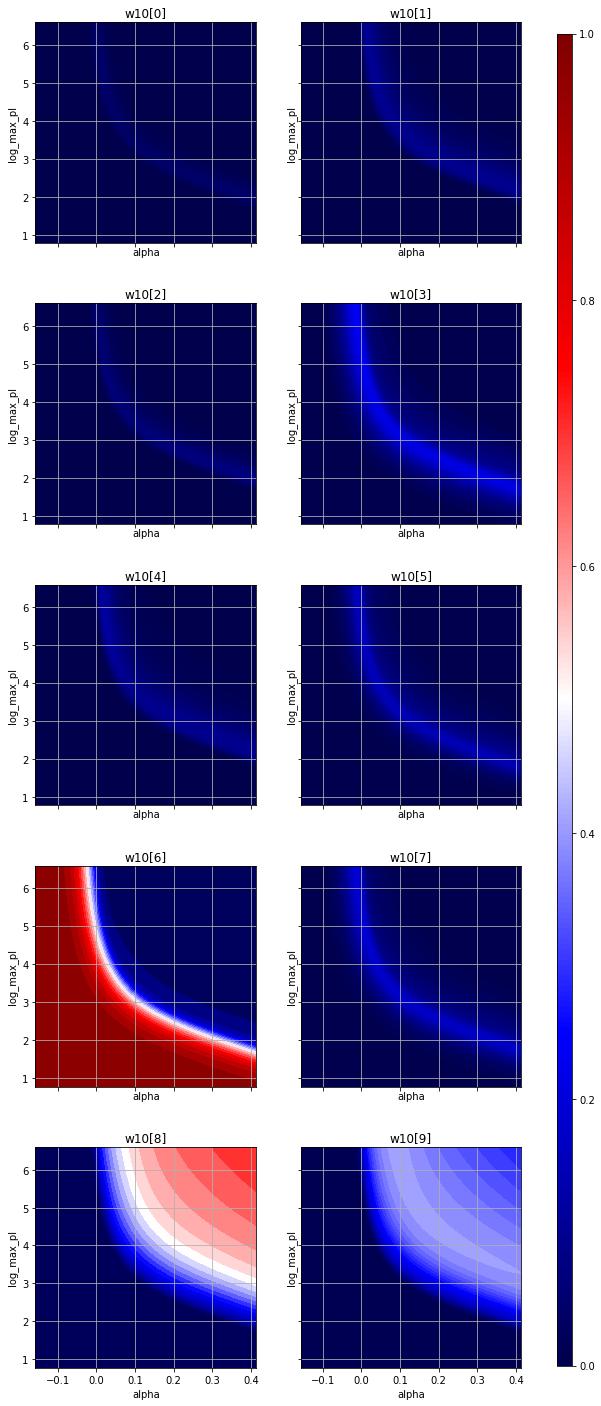

In [101]:
show_fns(w10)

In [102]:
w10.train(ds_la4, target_L=0.1)

Epoch 0 loss=-4.000027 W+c=[ -3.5707 -11.2761  -8.0585  11.4031 -10.4247   3.9467  -4.011    7.9466
   4.7775  -2.4075] det=0.000000 L=0.283790
Epoch 1 loss=-4.000026 W+c=[ -3.561  -11.2617  -8.0412  11.3968 -10.4135   3.9499  -4.0022   7.9436
   4.7885  -2.4344] det=0.000000 L=0.283823
Epoch 2 loss=-4.000027 W+c=[ -3.5513 -11.2472  -8.0237  11.3906 -10.4022   3.9531  -3.9935   7.9407
   4.7995  -2.4615] det=0.000000 L=0.283856
Epoch 3 loss=-4.000027 W+c=[ -3.5415 -11.2326  -8.0062  11.3843 -10.3908   3.9564  -3.9849   7.9377
   4.8104  -2.4886] det=0.000000 L=0.283890
Epoch 4 loss=-4.000027 W+c=[ -3.5317 -11.218   -7.9886  11.3781 -10.3793   3.9597  -3.9763   7.9348
   4.8212  -2.5158] det=0.000000 L=0.283923
Epoch 5 loss=-4.000028 W+c=[ -3.5218 -11.2033  -7.9709  11.3718 -10.3678   3.9631  -3.9679   7.9319
   4.8319  -2.5432] det=0.000000 L=0.283957
Epoch 6 loss=-4.000028 W+c=[ -3.5118 -11.1884  -7.9531  11.3655 -10.3562   3.9665  -3.9595   7.9291
   4.8425  -2.5706] det=0.000000 L=0

Epoch 57 loss=-4.000027 W+c=[ -2.9557 -10.3245  -6.9449  11.0346  -9.6619   4.1806  -3.6152   7.8021
   5.2176  -4.0216] det=0.000000 L=0.286250
Epoch 58 loss=-4.000027 W+c=[ -2.9442 -10.306   -6.9237  11.028   -9.6467   4.1852  -3.6097   7.7999
   5.2208  -4.0498] det=0.000000 L=0.286309
Epoch 59 loss=-4.000028 W+c=[ -2.9326 -10.2873  -6.9025  11.0214  -9.6315   4.1899  -3.6043   7.7976
   5.2239  -4.0779] det=0.000000 L=0.286369
Epoch 60 loss=-4.000027 W+c=[ -2.921  -10.2687  -6.8813  11.0148  -9.6162   4.1945  -3.5989   7.7954
   5.2267  -4.1059] det=0.000000 L=0.286428
Epoch 61 loss=-4.000027 W+c=[ -2.9095 -10.25    -6.8601  11.0082  -9.6009   4.1992  -3.5936   7.7932
   5.2294  -4.1338] det=0.000000 L=0.286489
Epoch 62 loss=-4.000028 W+c=[ -2.8979 -10.2313  -6.8388  11.0017  -9.5856   4.2039  -3.5883   7.7909
   5.2319  -4.1617] det=0.000000 L=0.286550
Epoch 63 loss=-4.000028 W+c=[ -2.8863 -10.2125  -6.8175  10.9951  -9.5702   4.2085  -3.5831   7.7887
   5.2343  -4.1895] det=0.000

Epoch 117 loss=-4.000028 W+c=[-2.2772 -9.2015 -5.6884 10.6567 -8.7321  4.4467 -3.346   7.6742  5.1026
 -5.5087] det=0.000000 L=0.291162
Epoch 118 loss=-4.000030 W+c=[-2.2667 -9.1836 -5.6687 10.6509 -8.7171  4.4506 -3.3423  7.6721  5.096
 -5.5289] det=0.000000 L=0.291271
Epoch 119 loss=-4.000029 W+c=[-2.2562 -9.1658 -5.649  10.6451 -8.7022  4.4544 -3.3387  7.6701  5.0893
 -5.549 ] det=0.000000 L=0.291380
Epoch 120 loss=-4.000028 W+c=[-2.2457 -9.148  -5.6294 10.6394 -8.6874  4.4583 -3.3351  7.668   5.0825
 -5.5689] det=0.000000 L=0.291491
Epoch 121 loss=-4.000029 W+c=[-2.2353 -9.1304 -5.6099 10.6336 -8.6726  4.4621 -3.3315  7.666   5.0756
 -5.5885] det=0.000000 L=0.291602
Epoch 122 loss=-4.000029 W+c=[-2.2249 -9.1127 -5.5905 10.6279 -8.6578  4.4659 -3.3279  7.6639  5.0685
 -5.608 ] det=0.000000 L=0.291714
Epoch 123 loss=-4.000028 W+c=[-2.2146 -9.0951 -5.5711 10.6222 -8.6431  4.4696 -3.3243  7.6619  5.0614
 -5.6274] det=0.000000 L=0.291827
Epoch 124 loss=-4.000028 W+c=[-2.2043 -9.0776 -5.

Epoch 178 loss=-4.000029 W+c=[-1.7181 -8.2381 -4.6336 10.3472 -7.9241  4.6304 -3.1565  7.5506  4.5524
 -6.4395] det=0.000000 L=0.299391
Epoch 179 loss=-4.000029 W+c=[-1.7104 -8.2247 -4.619  10.3429 -7.9128  4.6325 -3.1539  7.5486  4.542
 -6.4501] det=0.000000 L=0.299552
Epoch 180 loss=-4.000029 W+c=[-1.7028 -8.2113 -4.6044 10.3386 -7.9016  4.6345 -3.1513  7.5466  4.5315
 -6.4606] det=0.000000 L=0.299713
Epoch 181 loss=-4.000029 W+c=[-1.6952 -8.198  -4.59   10.3343 -7.8904  4.6366 -3.1487  7.5446  4.5211
 -6.4709] det=0.000000 L=0.299875
Epoch 182 loss=-4.000030 W+c=[-1.6877 -8.1849 -4.5757 10.3301 -7.8793  4.6385 -3.1462  7.5426  4.5106
 -6.4811] det=0.000000 L=0.300038
Epoch 183 loss=-4.000029 W+c=[-1.6802 -8.1717 -4.5614 10.3259 -7.8683  4.6405 -3.1436  7.5406  4.5001
 -6.4911] det=0.000000 L=0.300201
Epoch 184 loss=-4.000028 W+c=[-1.6728 -8.1587 -4.5472 10.3217 -7.8573  4.6424 -3.1411  7.5385  4.4897
 -6.5011] det=0.000000 L=0.300365
Epoch 185 loss=-4.000030 W+c=[-1.6654 -8.1457 -4.

Epoch 33 loss=-12.521416 W+c=[ 1.3202 -5.3244  0.2748  9.9686 -6.1965  6.1529 -4.1471  7.8439  2.1929
 -4.0513] det=0.000001 L=0.368015
Epoch 34 loss=-12.507185 W+c=[ 1.3543 -5.2802  0.3268  9.9587 -6.1703  6.154  -4.1472  7.8362  2.1711
 -4.0056] det=0.000001 L=0.370086
Epoch 35 loss=-12.492755 W+c=[ 1.3879 -5.2364  0.378   9.9488 -6.1444  6.1547 -4.1471  7.8284  2.1499
 -3.9602] det=0.000001 L=0.372166
Epoch 36 loss=-12.478115 W+c=[ 1.4212 -5.193   0.4284  9.9391 -6.1188  6.1551 -4.1467  7.8206  2.1292
 -3.9151] det=0.000001 L=0.374255
Epoch 37 loss=-12.463266 W+c=[ 1.4541 -5.15    0.4779  9.9293 -6.0934  6.1551 -4.1461  7.8127  2.1089
 -3.8703] det=0.000001 L=0.376353
Epoch 38 loss=-12.448199 W+c=[ 1.4866 -5.1073  0.5266  9.9197 -6.0682  6.1549 -4.1453  7.8047  2.0892
 -3.8259] det=0.000001 L=0.378461
Epoch 39 loss=-12.432910 W+c=[ 1.5188 -5.0649  0.5746  9.9101 -6.0432  6.1544 -4.1442  7.7967  2.0698
 -3.7817] det=0.000001 L=0.380579
Epoch 40 loss=-12.417416 W+c=[ 1.5507 -5.0229  0

Epoch 94 loss=-11.240219 W+c=[ 2.9938 -3.1467  2.4585  9.3826 -4.8808  5.9731 -3.9202  7.3719  1.4567
 -1.8869] det=0.000001 L=0.503270
Epoch 95 loss=-11.212177 W+c=[ 3.0175 -3.1192  2.4835  9.372  -4.8631  5.9702 -3.9149  7.3654  1.4508
 -1.8628] det=0.000001 L=0.505300
Epoch 96 loss=-11.184078 W+c=[ 3.0411 -3.0919  2.5082  9.3613 -4.8455  5.9673 -3.9095  7.3589  1.445
 -1.8391] det=0.000001 L=0.507309
Epoch 97 loss=-11.155962 W+c=[ 3.0646 -3.0649  2.5327  9.3505 -4.8281  5.9646 -3.9042  7.3525  1.4393
 -1.8157] det=0.000001 L=0.509294
Epoch 98 loss=-11.127838 W+c=[ 3.088  -3.0382  2.5569  9.3397 -4.8109  5.9619 -3.8989  7.3461  1.4337
 -1.7927] det=0.000001 L=0.511257
Epoch 99 loss=-11.099719 W+c=[ 3.1114 -3.0118  2.5809  9.3287 -4.7938  5.9592 -3.8935  7.3397  1.4283
 -1.7701] det=0.000001 L=0.513194
Epoch 100 loss=-11.071623 W+c=[ 3.1346 -2.9857  2.6046  9.3177 -4.7769  5.9566 -3.8881  7.3334  1.423
 -1.7478] det=0.000001 L=0.515106
Epoch 101 loss=-11.043571 W+c=[ 3.1578 -2.9598  2

Epoch 154 loss=-9.910306 W+c=[ 4.3155 -1.9075  3.6645  8.6265 -4.0946  5.8824 -3.5949  7.0021  1.2427
 -0.9417] det=0.000002 L=0.579597
Epoch 155 loss=-9.897072 W+c=[ 4.3366 -1.8916  3.6819  8.6127 -4.0856  5.8814 -3.5897  6.9958  1.2405
 -0.9317] det=0.000002 L=0.580213
Epoch 156 loss=-9.884043 W+c=[ 4.3577 -1.8757  3.6993  8.599  -4.0767  5.8805 -3.5845  6.9894  1.2384
 -0.9219] det=0.000002 L=0.580815
Epoch 157 loss=-9.871196 W+c=[ 4.3787 -1.86    3.7167  8.5853 -4.0679  5.8795 -3.5794  6.983   1.2363
 -0.9122] det=0.000002 L=0.581403
Epoch 158 loss=-9.858574 W+c=[ 4.3997 -1.8443  3.7341  8.5716 -4.0592  5.8785 -3.5742  6.9766  1.2343
 -0.9026] det=0.000002 L=0.581975
Epoch 159 loss=-9.846096 W+c=[ 4.4208 -1.8286  3.7514  8.5579 -4.0507  5.8775 -3.5691  6.9702  1.2322
 -0.893 ] det=0.000002 L=0.582535
Epoch 160 loss=-9.833774 W+c=[ 4.4417 -1.8131  3.7687  8.5443 -4.0422  5.8765 -3.564   6.9638  1.2302
 -0.8836] det=0.000002 L=0.583082
Epoch 161 loss=-9.821649 W+c=[ 4.4627 -1.7975  3

Epoch 215 loss=-9.148489 W+c=[ 5.516  -0.9766  4.7222  7.8728 -3.6799  5.819  -3.3237  6.637   1.1323
 -0.4634] det=0.000002 L=0.613088
Epoch 216 loss=-9.132010 W+c=[ 5.5329 -0.9609  4.7397  7.863  -3.6749  5.8184 -3.3203  6.6323  1.1306
 -0.4569] det=0.000002 L=0.613659
Epoch 217 loss=-9.115263 W+c=[ 5.5498 -0.9452  4.7573  7.8533 -3.6698  5.8179 -3.317   6.6277  1.1289
 -0.4504] det=0.000002 L=0.614224
Epoch 218 loss=-9.098276 W+c=[ 5.5665 -0.9295  4.7749  7.8437 -3.6649  5.8174 -3.3137  6.6232  1.1272
 -0.444 ] det=0.000002 L=0.614781
Epoch 219 loss=-9.081057 W+c=[ 5.583  -0.9137  4.7925  7.8343 -3.66    5.817  -3.3104  6.6187  1.1254
 -0.4376] det=0.000002 L=0.615330
Epoch 220 loss=-9.063559 W+c=[ 5.5994 -0.8979  4.8101  7.8249 -3.6551  5.8166 -3.3072  6.6144  1.1237
 -0.4312] det=0.000002 L=0.615870
Epoch 221 loss=-9.045783 W+c=[ 5.6157 -0.8821  4.8277  7.8157 -3.6503  5.8163 -3.304   6.6101  1.122
 -0.4248] det=0.000002 L=0.616402
Epoch 222 loss=-9.027842 W+c=[ 5.6318 -0.8662  4.

Epoch 276 loss=-10.170479 W+c=[ 6.2171  0.0056  5.7244  7.4788 -3.4672  5.8911 -3.1566  6.5006  1.0335
 -0.0845] det=0.000003 L=0.631472
Epoch 277 loss=-7.982989 W+c=[ 6.1914 -0.0038  5.7018  7.4496 -3.4716  5.877  -3.1321  6.4803  1.0383
 -0.0776] det=0.000003 L=0.627617
Epoch 278 loss=-10.221786 W+c=[ 6.2051  0.0189  5.7242  7.4516 -3.4665  5.8825 -3.1341  6.484   1.0357
 -0.0699] det=0.000003 L=0.629310
Epoch 279 loss=-10.318843 W+c=[ 6.1805  0.0104  5.7027  7.4233 -3.4703  5.8687 -3.1105  6.4642  1.0405
 -0.063 ] det=0.000003 L=0.625614
Epoch 280 loss=-10.406300 W+c=[ 6.1575  0.0031  5.6828  7.3961 -3.4733  5.8553 -3.0878  6.4451  1.0451
 -0.056 ] det=0.000003 L=0.622058
Epoch 281 loss=-8.161476 W+c=[ 6.136  -0.0033  5.6642  7.3698 -3.4757  5.8423 -3.066   6.4265  1.0497
 -0.0489] det=0.000003 L=0.620121
Epoch 282 loss=-10.410513 W+c=[ 6.1538  0.0231  5.6906  7.3743 -3.4687  5.8486 -3.0701  6.4318  1.0464
 -0.0401] det=0.000003 L=0.621386
Epoch 283 loss=-10.485419 W+c=[ 6.133   0.0

Epoch 336 loss=-13.883733 W+c=[ 5.4625  0.0079  5.212   6.5265 -3.3844  5.358  -2.4513  5.7858  1.1661
  0.1911] det=0.000004 L=0.589176
Epoch 337 loss=-13.885307 W+c=[ 5.4535  0.0113  5.2081  6.5169 -3.3805  5.351  -2.4458  5.7775  1.167
  0.1942] det=0.000004 L=0.589406
Epoch 338 loss=-13.884886 W+c=[ 5.445   0.0151  5.2047  6.5077 -3.3765  5.3442 -2.4406  5.7696  1.1678
  0.1974] det=0.000004 L=0.589642
Epoch 339 loss=-13.882762 W+c=[ 5.4368  0.0194  5.2019  6.499  -3.3723  5.3376 -2.4358  5.7619  1.1683
  0.2007] det=0.000004 L=0.589881
Epoch 340 loss=-13.879065 W+c=[ 5.4289  0.0241  5.1995  6.4906 -3.368   5.3313 -2.4313  5.7545  1.1687
  0.2041] det=0.000004 L=0.590125
Epoch 341 loss=-13.874022 W+c=[ 5.4213  0.0292  5.1975  6.4826 -3.3636  5.3252 -2.4271  5.7474  1.169
  0.2075] det=0.000004 L=0.590371
Epoch 342 loss=-13.867718 W+c=[ 5.4139  0.0346  5.1959  6.4748 -3.3592  5.3193 -2.4231  5.7406  1.1691
  0.211 ] det=0.000004 L=0.590621
Epoch 343 loss=-13.860375 W+c=[ 5.4067  0.0

Epoch 396 loss=-13.189358 W+c=[ 5.0102  0.3985  5.1531  6.2597 -3.128   5.1533 -2.3568  5.5457  1.1104
  0.3919] det=0.000005 L=0.596016
Epoch 397 loss=-13.176743 W+c=[ 5.0014  0.4041  5.1505  6.2576 -3.1244  5.1519 -2.3565  5.544   1.1091
  0.3948] det=0.000005 L=0.596028
Epoch 398 loss=-13.164158 W+c=[ 4.9925  0.4098  5.1478  6.2554 -3.1209  5.1506 -2.3563  5.5422  1.1078
  0.3977] det=0.000005 L=0.596035
Epoch 399 loss=-13.151528 W+c=[ 4.9836  0.4153  5.1451  6.2534 -3.1174  5.1493 -2.356   5.5406  1.1066
  0.4006] det=0.000005 L=0.596040
Epoch 400 loss=-13.138976 W+c=[ 4.9747  0.4209  5.1423  6.2513 -3.114   5.1481 -2.3558  5.5389  1.1053
  0.4035] det=0.000005 L=0.596040
Epoch 401 loss=-13.126354 W+c=[ 4.9658  0.4263  5.1394  6.2493 -3.1105  5.1469 -2.3556  5.5374  1.104
  0.4064] det=0.000005 L=0.596037
Epoch 402 loss=-13.113710 W+c=[ 4.9568  0.4317  5.1364  6.2474 -3.1071  5.1457 -2.3554  5.5358  1.1027
  0.4092] det=0.000005 L=0.596033
Epoch 403 loss=-13.101107 W+c=[ 4.9478  0.

Epoch 456 loss=-12.434588 W+c=[ 4.4769  0.6629  4.9107  6.1844 -2.952   5.1237 -2.3578  5.5016  1.0414
  0.5569] det=0.000006 L=0.594737
Epoch 457 loss=-12.422634 W+c=[ 4.4687  0.6664  4.9059  6.1837 -2.9495  5.1237 -2.358   5.5016  1.0404
  0.5597] det=0.000006 L=0.594686
Epoch 458 loss=-12.410687 W+c=[ 4.4605  0.6698  4.9012  6.1831 -2.9471  5.1238 -2.3582  5.5016  1.0395
  0.5624] det=0.000006 L=0.594635
Epoch 459 loss=-12.398786 W+c=[ 4.4523  0.6732  4.8965  6.1825 -2.9447  5.1239 -2.3584  5.5017  1.0386
  0.5652] det=0.000006 L=0.594583
Epoch 460 loss=-12.387012 W+c=[ 4.4442  0.6765  4.8917  6.1819 -2.9423  5.124  -2.3587  5.5018  1.0376
  0.568 ] det=0.000006 L=0.594530
Epoch 461 loss=-12.375172 W+c=[ 4.4361  0.6799  4.887   6.1813 -2.9399  5.1241 -2.3589  5.5019  1.0367
  0.5707] det=0.000006 L=0.594478
Epoch 462 loss=-12.363440 W+c=[ 4.4281  0.6832  4.8823  6.1808 -2.9375  5.1242 -2.3591  5.502   1.0358
  0.5735] det=0.000006 L=0.594425
Epoch 463 loss=-12.351767 W+c=[ 4.4201  0

Sequential(
  (0): Scaler()
  (1): Sequential(
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
  (2): Softmax(dim=-1)
  (3): Linear(in_features=10, out_features=1, bias=False)
)

In [103]:
quality(test_ds, [w_la4, w10], channel_names[1], "test")

test            1-w₄[α,p] R[w₄[α,p]]     1-w10    R[w10]
B⁺→K⁺ee          0.940269   1.042236  0.937055  1.045768
B⁺→K⁺J/ψ(→ee)    0.979982        1.0  0.979943       1.0
B⁺→K⁺ψ(2S)(→ee)  0.986366   0.993528  0.986728  0.993124
D⁺→π⁺φ(→ee)      0.930137   1.053589  0.930107   1.05358

In [104]:
show_fns(w10)

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, d in enumerate([w_la4, w10]):
    sc = d.model[0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i], color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i], vmax=None)
plt.show()